In [1]:
import numpy as np
import pandas as pd
import imp
import os
import sys
import tensorflow as tf
from numba import njit
from functools import lru_cache
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import random

import stops

tf.random.set_seed(1234)

imp.reload(stops)

<module 'stops' from 'C:\\Users\\graham\\code_projects\\bus_prediction\\src\\stops.py'>

# notes
* make a class / functions that:
* make a pd dataframe of all of the categorical columns
* ordianl encode them - cat.codes
* get cardinality of each column
* turn column into np array
* send it out in it's current shape
* have a layer that splits it (tf.split, does it need to be in a lambda layer?)
* for the list of splits embed each of them using their cardinality and some set outputdim (30?)
* concate them all with the non-categorical labels
* lstm them

another idea
* you can also find the categories that dont change
* put them into a different dataframe
* split them 
* embed them
* concat them
* merge them with the post lstm

In [2]:
url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(
        Audio(
            url=url_done,
            autoplay=True,
        )
    )

In [3]:
data_dir = os.path.join(os.getcwd(), "..", "data")

In [4]:
direction = 1

In [23]:
def df_pop(df, labels):
    popped = df[labels]
    df = df.drop(columns=labels)
    return df, popped


trips, dates, labels = None, None, None
lstm_dir = os.path.join(data_dir, "trips_for_lstm")
files = [
    f + "_direction_" + str(direction) + ".npy"
    for f in ["trips", "dates", "time_cat", "labels"]
]

recompute = True

if recompute:

    pickle_path = os.path.join(data_dir, "mega_pickle")
    df = pd.read_pickle(pickle_path)
    df = df.head(10000)
    
    df = df.drop(columns=["route_number", "time_cat_stop_time", "time_cat_leave_time"])

    df = df.sort_values(["service_date", "train", "trip_number", "stop_time"])
    df = df.reset_index(drop=True)

    df = df[df["direction"] == direction]

    trips = df.groupby(["service_date", "train", "trip_number"])
    trips = [trip for _, trip in trips]

    hist = {}
    for trip in trips:
        trip = trip.drop_duplicates("location_id")
        s = tuple(trip["location_id"].to_list())
        if s in hist:
            hist[s] = hist[s] + 1
        else:
            hist[s] = 1

    sorted_stops = sorted(hist.items(), key=lambda x: x[1], reverse=True)
    most_common_stops = list(sorted_stops[0][0])

    x1 = []
    x2 = []
    x3 = []
    y = []
    for trip in trips:
        trip = trip.drop_duplicates("location_id")
        if trip["location_id"].to_list() == most_common_stops:
            dtypes = trip.dtypes
            categories = dtypes[dtypes == 'category']
            non-categories = 
            assert 2 == 3
            
            
            trip = trip.drop(
                columns=[
                    "service_date",
                    "stop_time",
                    "leave_time",
                    "vehicle_number",
                    "location_id",
                    "train",
                ]
            )
            trip, date = df_pop(trip, ["day_of_week", "day_of_year"])
            date = date.iloc[0]
            labels = trip["arrival_deviance"]
            time_cat = trip.pop("time_cat_arrive_time")

            trip = pd.get_dummies(trip)

            trip = np.asarray(trip).astype(np.float32)
            date = np.asarray(date).astype(np.float32)
            time_cat = np.asarray(time_cat).astype(np.float32)
            labels = np.asarray(labels).astype(np.float32)

            x1.append(trip)
            x2.append(date)
            x3.append(time_cat)
            y.append(labels)

    trips = np.stack(x1)
    dates = np.stack(x2)
    time_cat = np.stack(x3)
    labels = np.stack(y)

    arrays = [trips, dates, time_cat, labels]

    for file_name, array in zip(files, arrays):
        file_path = os.path.join(lstm_dir, file_name)
        np.save(file_path, array)

else:
    arrays = []
    for file_name in files:
        file_path = os.path.join(lstm_dir, file_name)
        arrays.append(np.load(file_path))
    trips, dates, time_cats, labels = arrays


print(trips.shape, time_cat.shape, dates.shape, labels.shape)
datalen = trips.shape[0]
num_stops = trips.shape[1]
trip_width = trips.shape[2]

direction               category
door                    category
lift                    category
location_id             category
service_key             category
train                   category
vehicle_number          category
day_of_year             category
day_of_week             category
time_cat_arrive_time    category
dtype: object


AssertionError: 

In [6]:
trip_shape = (num_stops, trip_width)
cat_shape = ()
time_cat_shape = (num_stops,)
label_shape = (num_stops,)


num_samples = 10
datalen = datalen * num_samples


def data_generator(trips, dates, time_cats, labels):
    for trip, date, time_cat, label in zip(trips, time_cats, dates, labels):
        random_list = random.sample(range(2, 79), num_samples - 2)
        samples = [80] + sorted(random_list, reverse=True) + [2]
        for i in samples:
            trip[i:] = 0
            #             print(trip.shape, time_cat.shape, date[1].shape, date[0].shape)
            yield {
                "trip": trip,
                "time_cat": time_cat,
                "date": date[1],
                "day": date[0],
                "num_samples": i,
            }, label


def get_dataset(trips, dates, time_cat, labels):
    return tf.data.Dataset.from_generator(
        data_generator,
        args=[trips, time_cat, dates, labels],
        output_signature=(
            {
                "trip": tf.TensorSpec(shape=trip_shape, dtype=tf.float32),
                "time_cat": tf.TensorSpec(shape=time_cat_shape, dtype=tf.int32),
                "date": tf.TensorSpec(shape=cat_shape, dtype=tf.int32),
                "day": tf.TensorSpec(shape=cat_shape, dtype=tf.int32),
                "num_samples": tf.TensorSpec(shape=cat_shape, dtype=tf.int32),
            },
            tf.TensorSpec(shape=label_shape, dtype=tf.float32),
        ),
    )

In [7]:
batch_size = 32

train = 0.8
val = 0.1
test = 0.1
assert train + val + test == 1

train = int(train * datalen)
val = int(val * datalen)
test = int(test * datalen)

print(train, val, test)

dataset = get_dataset(trips, dates, time_cat, labels)

train_dataset = dataset.take(train).shuffle(1000).batch(batch_size)
val_dataset = dataset.skip(train).take(val).batch(batch_size)
test_dataset = dataset.skip(train + val).batch(batch_size)

121344 15168 15168


In [8]:
drop_rate = 0.2

trip_input = tf.keras.Input(shape=trip_shape, name="trip")
time_cat_input = tf.keras.Input(shape=time_cat_shape, name="time_cat")
date_input = tf.keras.Input(shape=cat_shape, name="date")
day_input = tf.keras.Input(shape=cat_shape, name="day")

trip = trip_input
time_cat = time_cat_input
date = date_input
day = day_input


time_cat = tf.keras.layers.Embedding(275, 30)(time_cat)

trip = tf.keras.layers.BatchNormalization()(trip)
trip = tf.keras.layers.Concatenate(axis=2)([trip, time_cat])
trip = tf.keras.layers.LSTM(20, return_sequences=True)(trip)
trip = tf.keras.layers.Flatten()(trip)

date = tf.keras.layers.Embedding(365, 10)(date)
date = tf.keras.layers.Flatten()(date)

day = tf.keras.layers.Embedding(7, 10)(day)
day = tf.keras.layers.Flatten()(day)

pred = tf.keras.layers.concatenate([trip, date, day])
trip = tf.keras.layers.BatchNormalization()(trip)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(1000, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(500, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(50, activation="relu")(pred)
pred = tf.keras.layers.Dense(num_stops, name="output")(pred)

model = tf.keras.Model(
    inputs=[trip_input, time_cat_input, date_input, day_input],
    outputs=[pred],
)

total parameters: 2,270,547


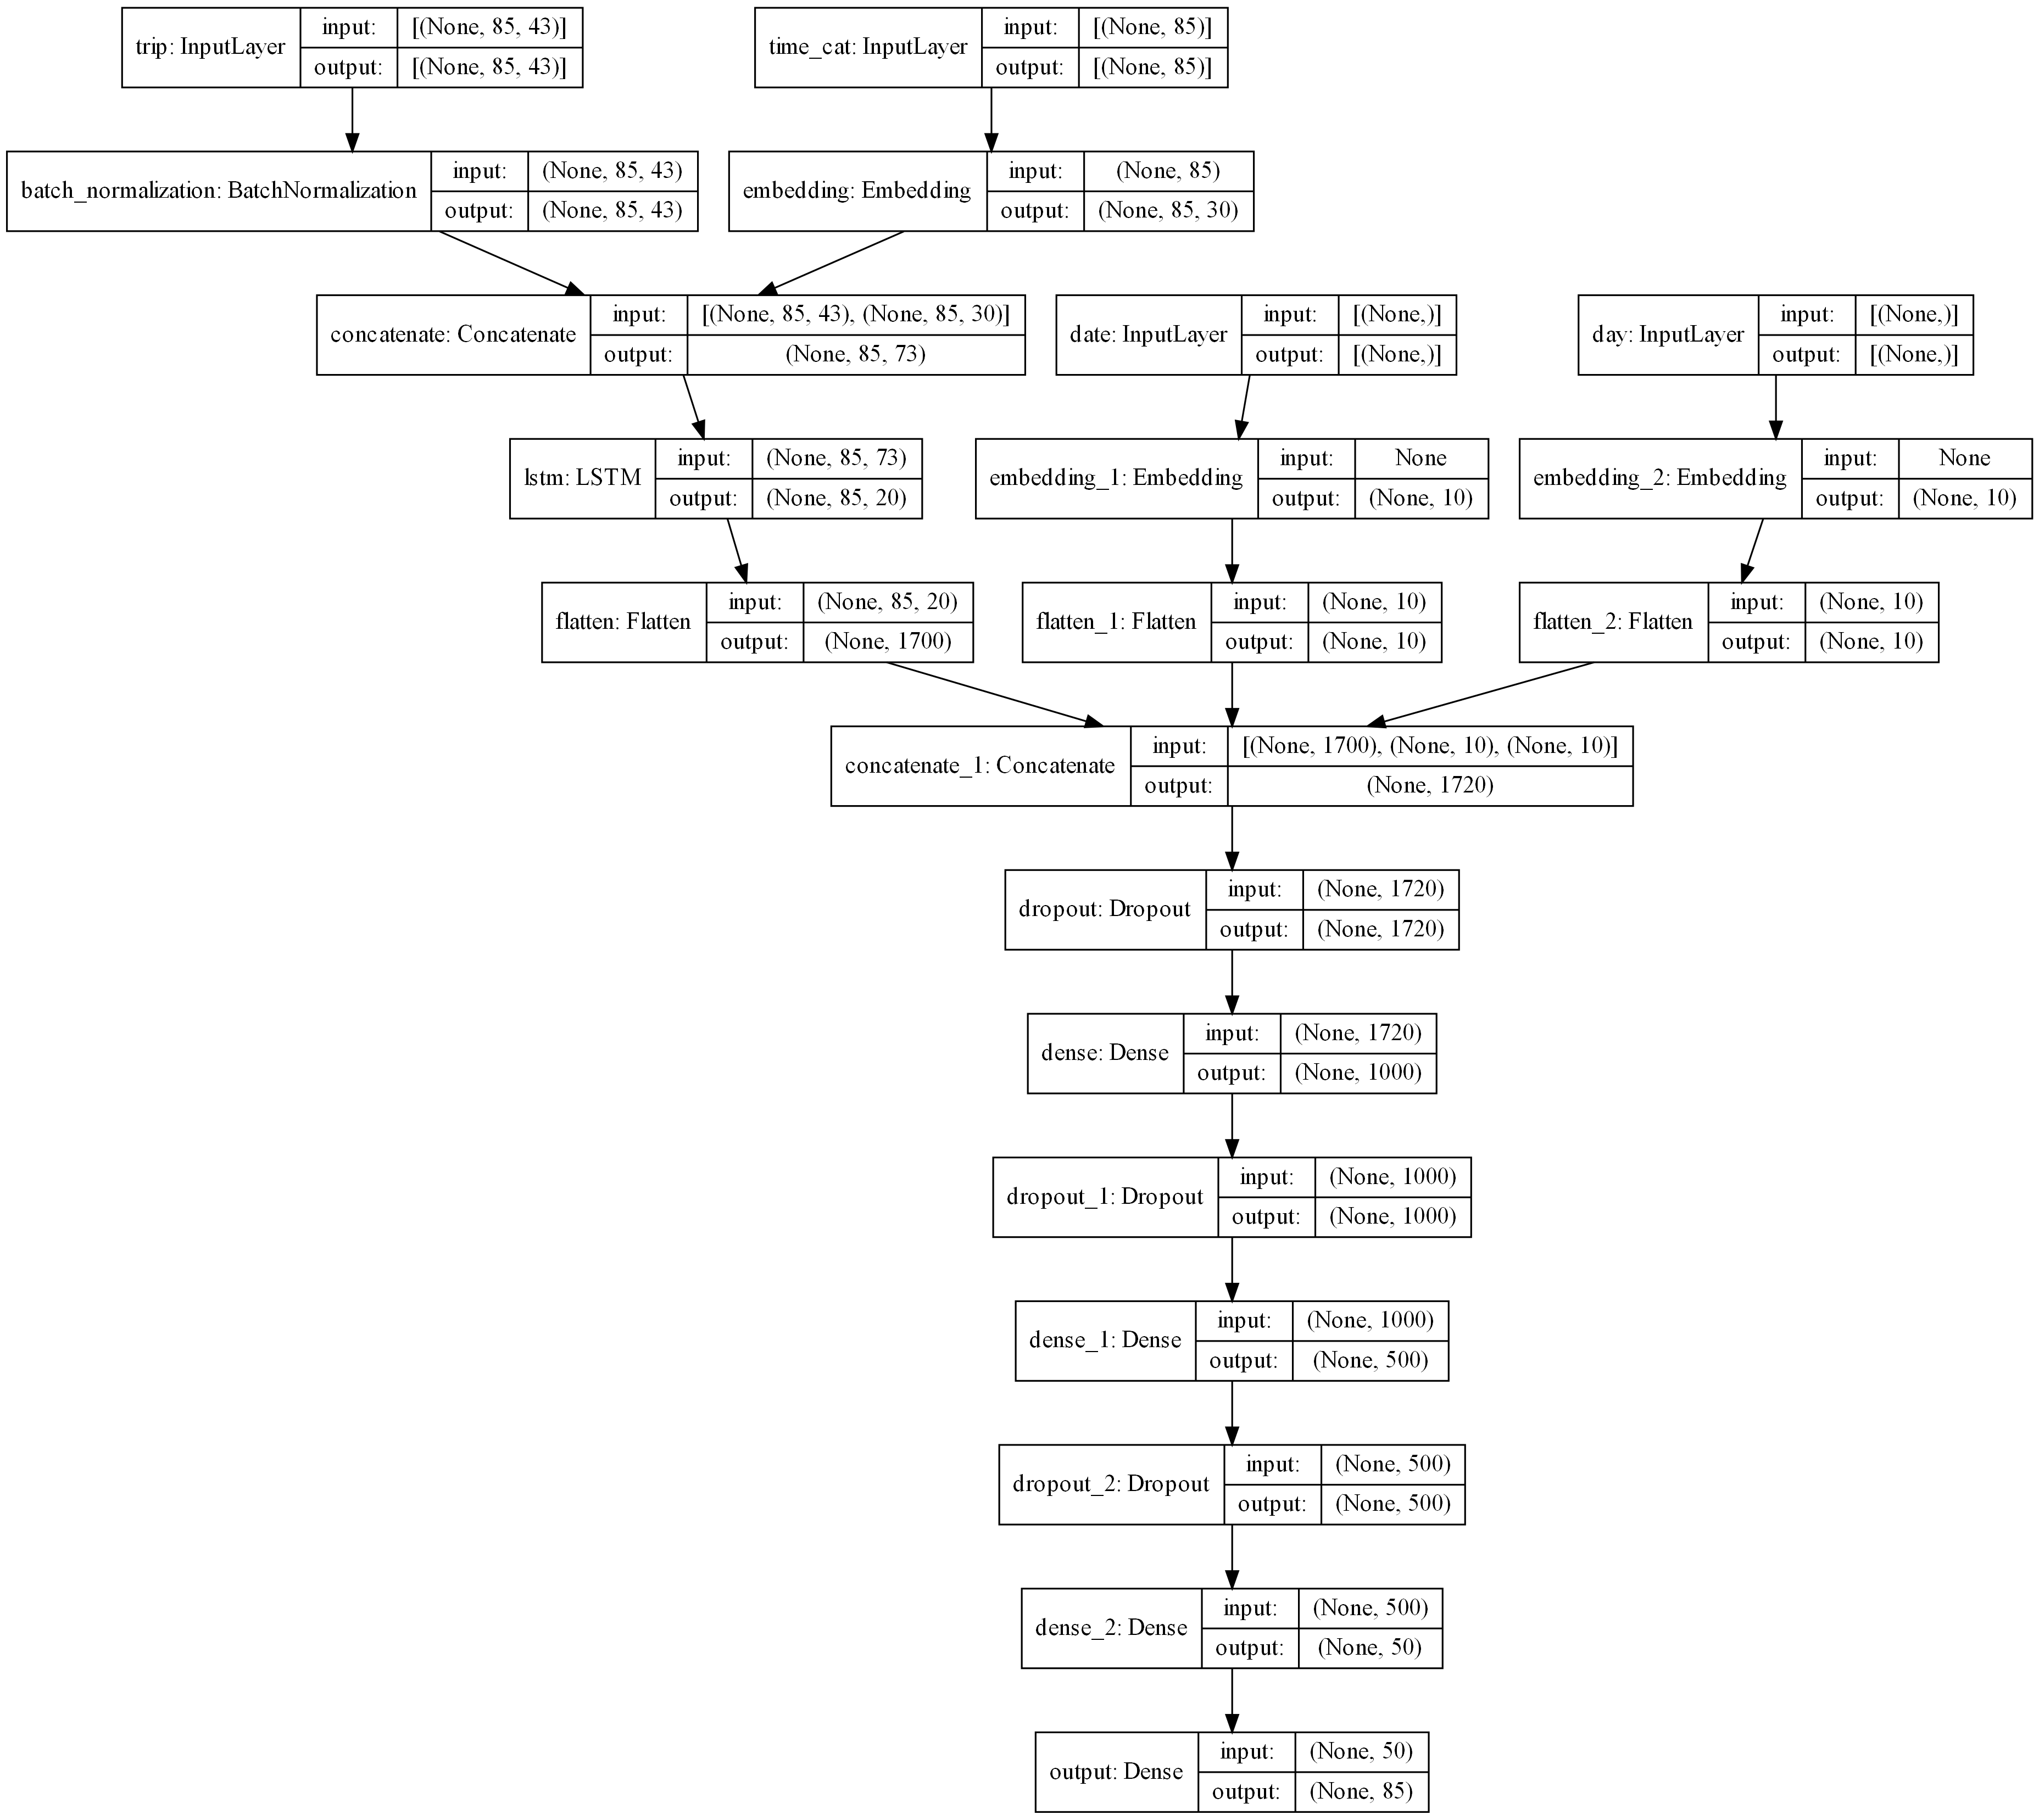

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["mean_absolute_error", "mean_squared_error"],
)
print("total parameters: {:,}".format(model.count_params()))
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, dpi=227)

In [10]:
monitor_param = "val_mean_squared_error"


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

nan_terminate = tf.keras.callbacks.TerminateOnNaN()

lr_plateau_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_param, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_param, patience=5  # , restore_best_weights=True
)

model_dir = os.path.join(data_dir, "model")
checkpoint_filepath = os.path.join(model_dir, "checkpoint")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_param,
    mode="min",
    save_best_only=True,
)

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, nan_terminate],
)

Num GPUs Available:  1
Epoch 1/100


C:\Users\graham\AppData\Local\pypoetry\Cache\virtualenvs\bus-prediction-iVe0Nv0y-py3.8\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['num_samples'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


3792/3792 [==============================] - 85s 22ms/step - loss: 10914.5879 - mean_absolute_error: 58.6720 - mean_squared_error: 10914.5879 - val_loss: 8583.4854 - val_mean_absolute_error: 53.8379 - val_mean_squared_error: 8583.4854
Epoch 2/100
3792/3792 [==============================] - 84s 22ms/step - loss: 7334.2109 - mean_absolute_error: 48.1948 - mean_squared_error: 7334.2109 - val_loss: 7112.1455 - val_mean_absolute_error: 46.5221 - val_mean_squared_error: 7112.1455
Epoch 3/100
3792/3792 [==============================] - 83s 22ms/step - loss: 5421.0068 - mean_absolute_error: 43.1506 - mean_squared_error: 5421.0068 - val_loss: 6521.1929 - val_mean_absolute_error: 44.3250 - val_mean_squared_error: 6521.1929
Epoch 4/100
3792/3792 [==============================] - 82s 22ms/step - loss: 4729.3560 - mean_absolute_error: 40.4296 - mean_squared_error: 4729.3560 - val_loss: 6196.5713 - val_mean_absolute_error: 41.8224 - val_mean_squared_error: 6196.5713
Epoch 5/100
3792/3792 [=======

KeyboardInterrupt: 

In [12]:
model.load_weights(checkpoint_filepath)

In [13]:
model.evaluate(test_dataset)

474/474 [==============================] - 24s 9ms/step - loss: 5404.5342 - mean_absolute_error: 39.9571 - mean_squared_error: 5404.5342


[5404.5341796875, 39.957122802734375, 5404.5341796875]

In [14]:
preds = model.predict(test_dataset)

In [15]:
print(preds.shape)

(15168, 85)


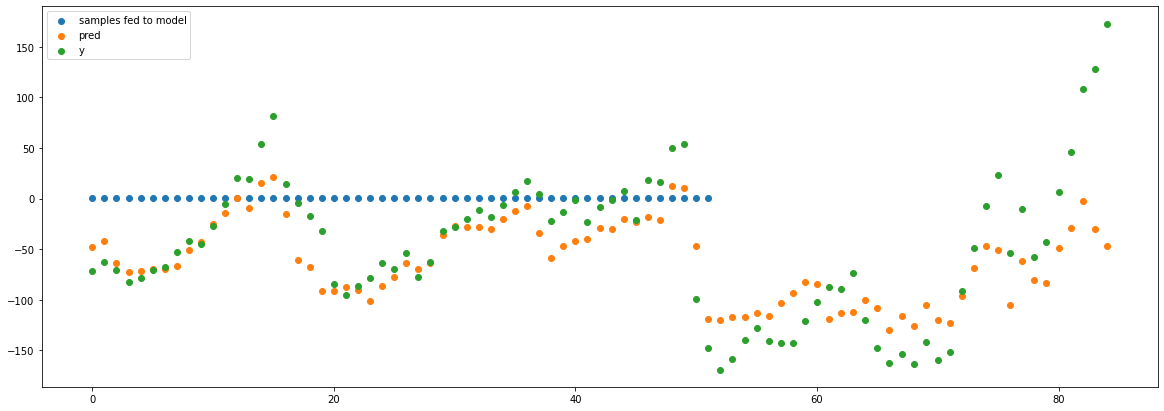

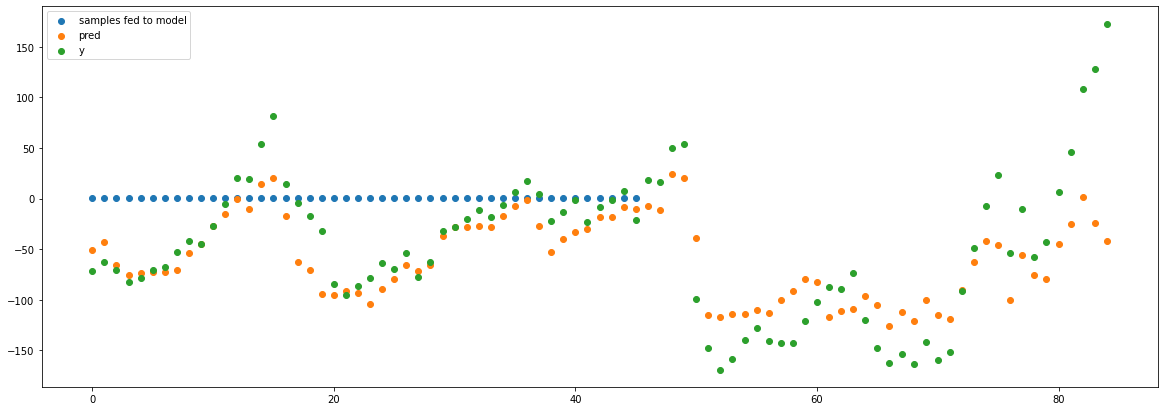

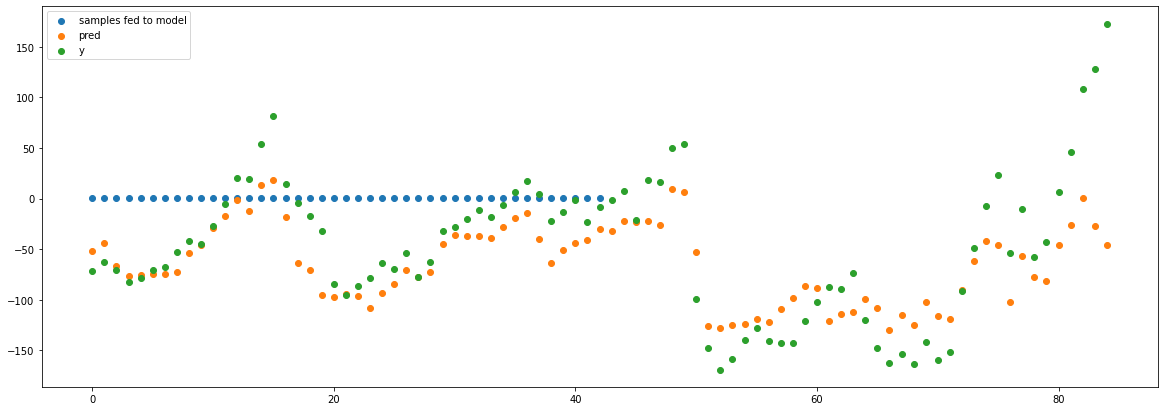

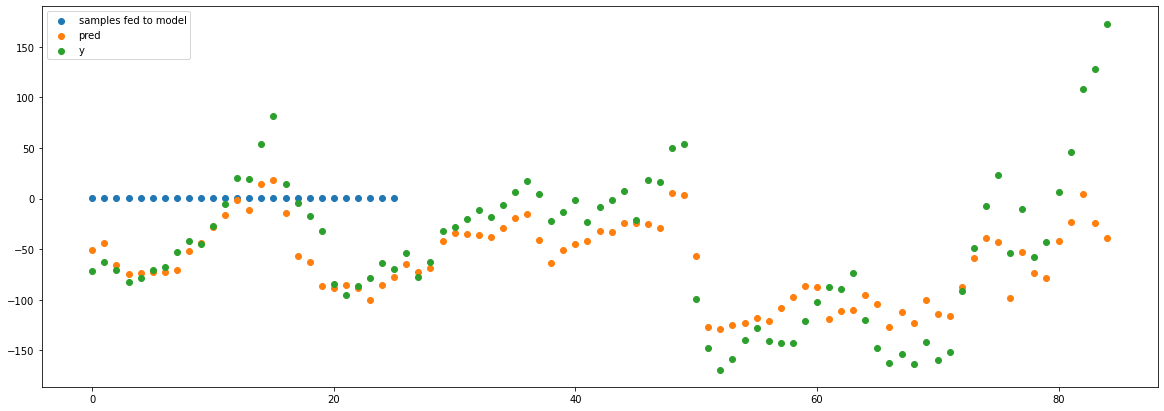

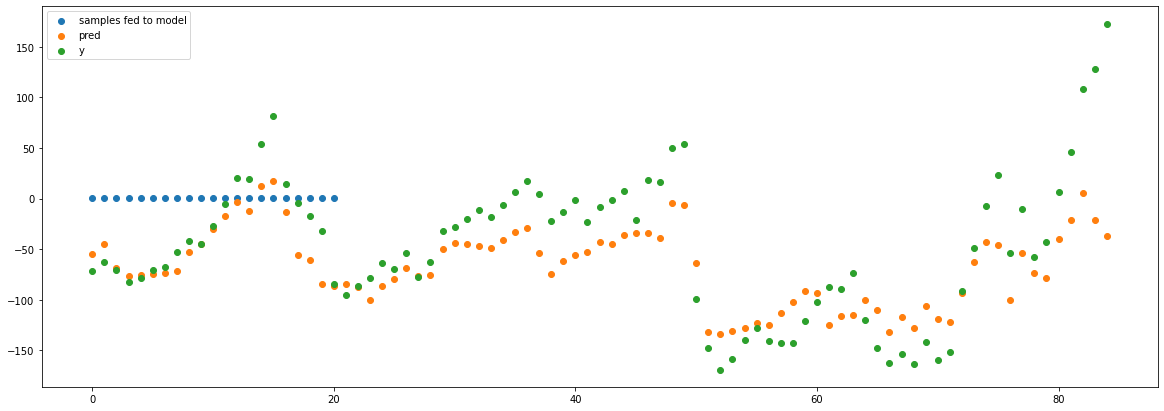

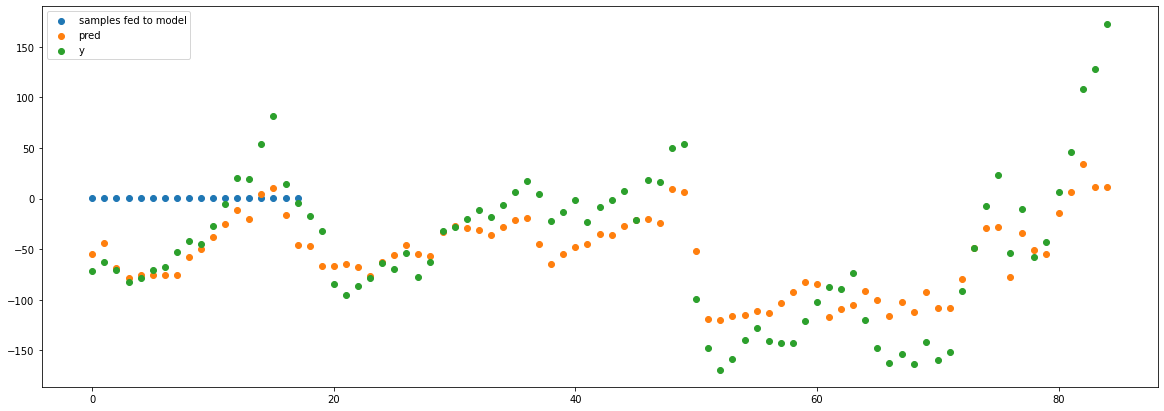

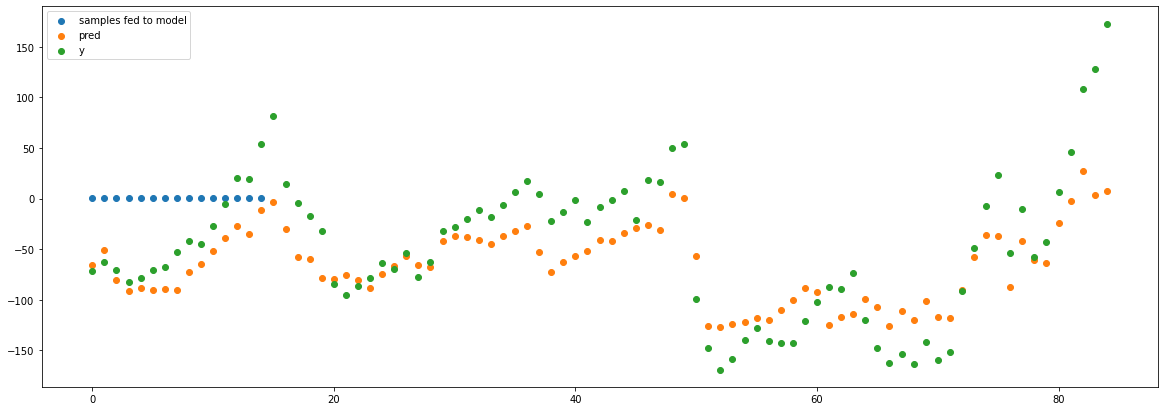

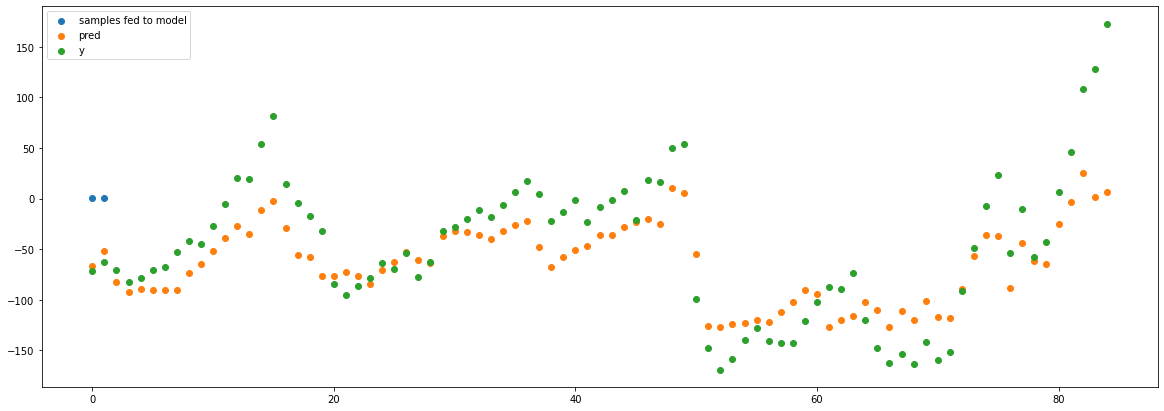

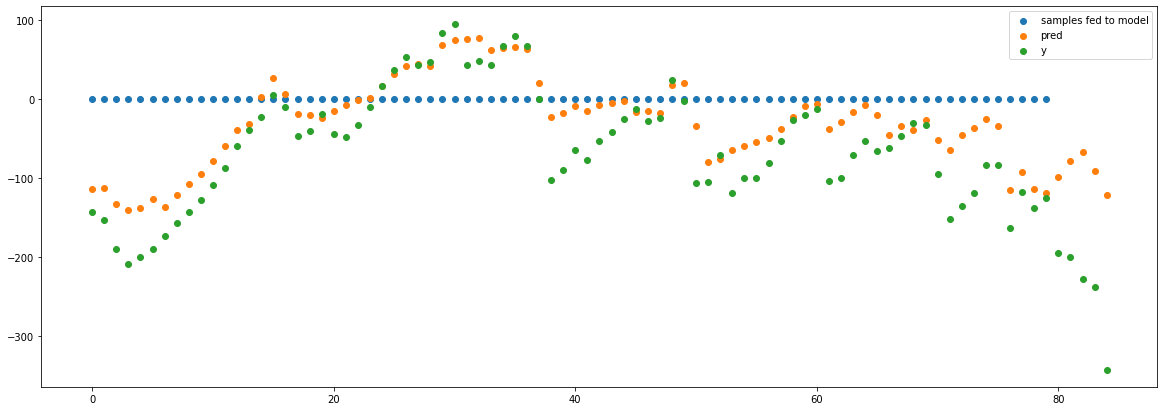

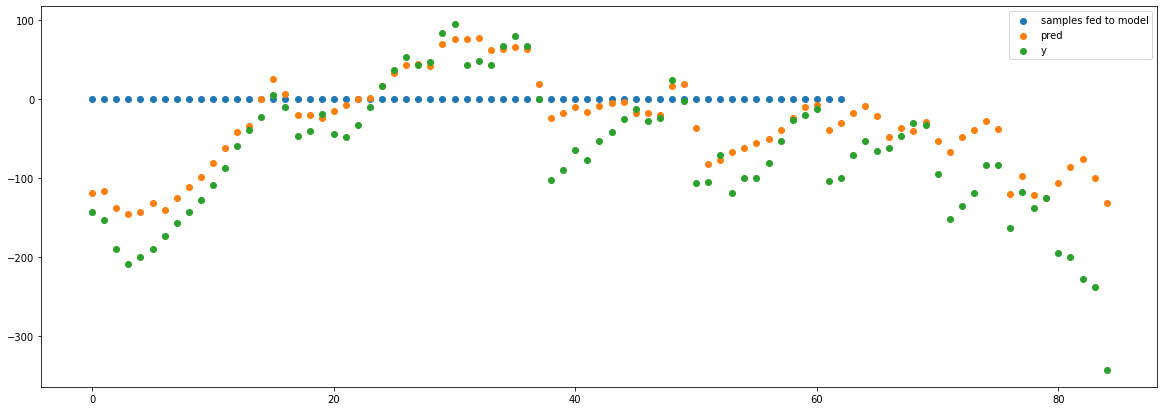

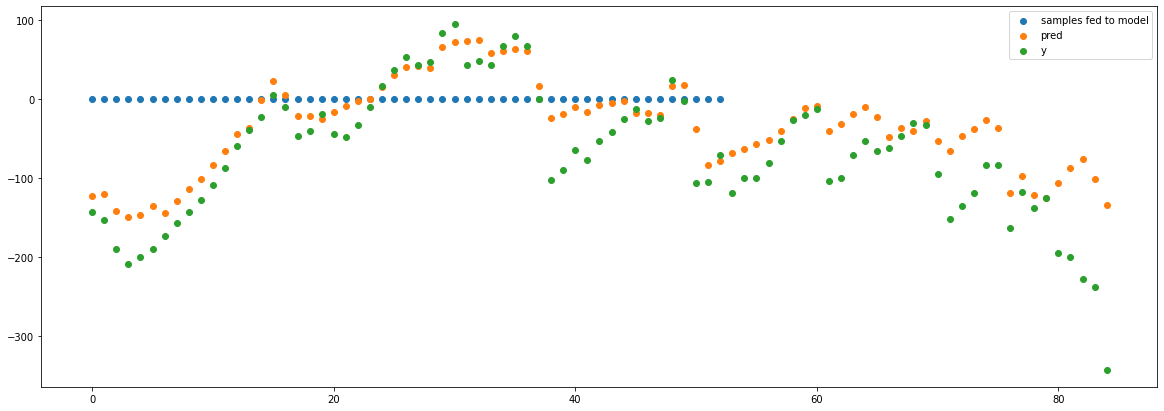

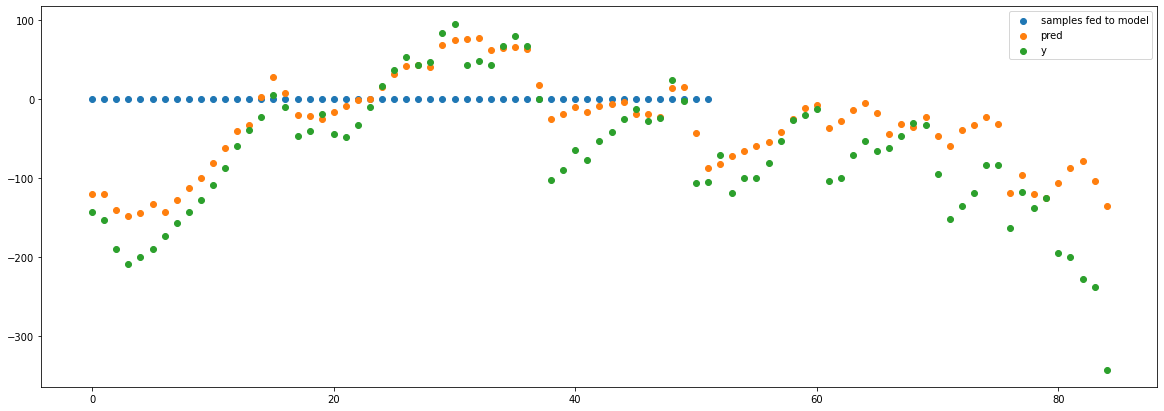

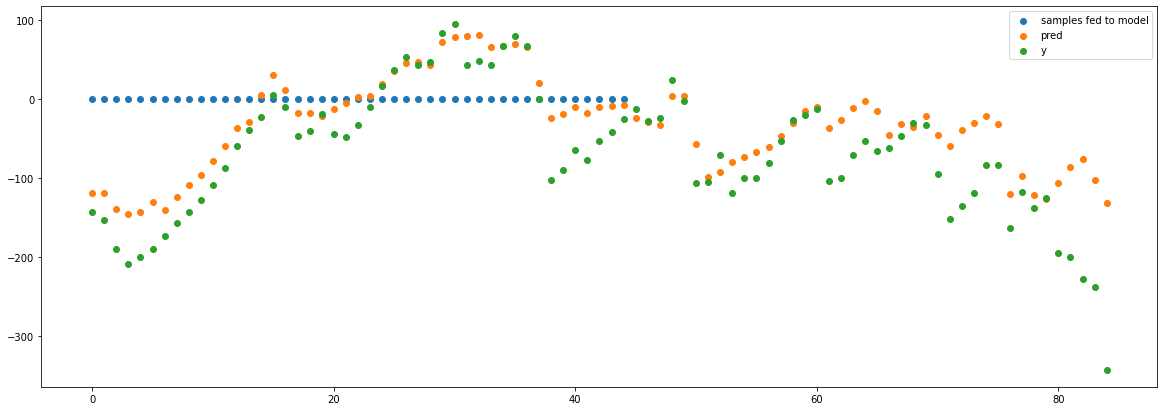

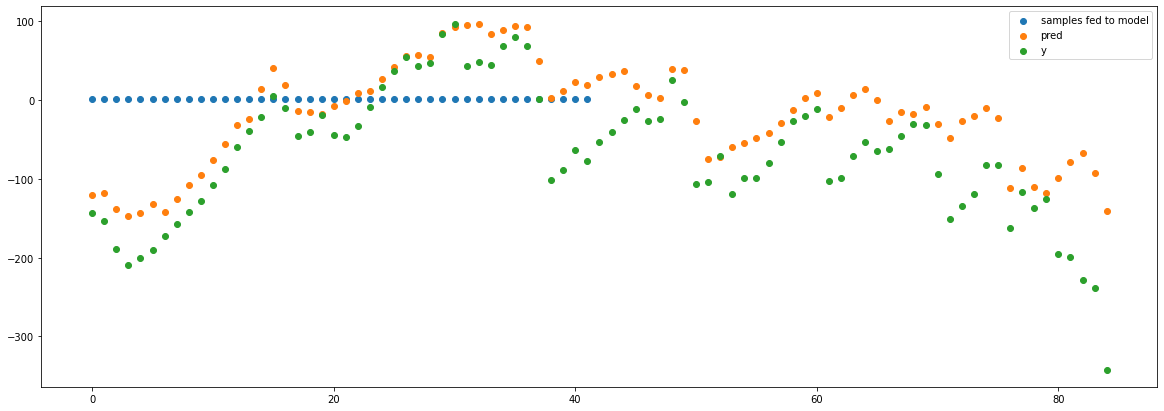

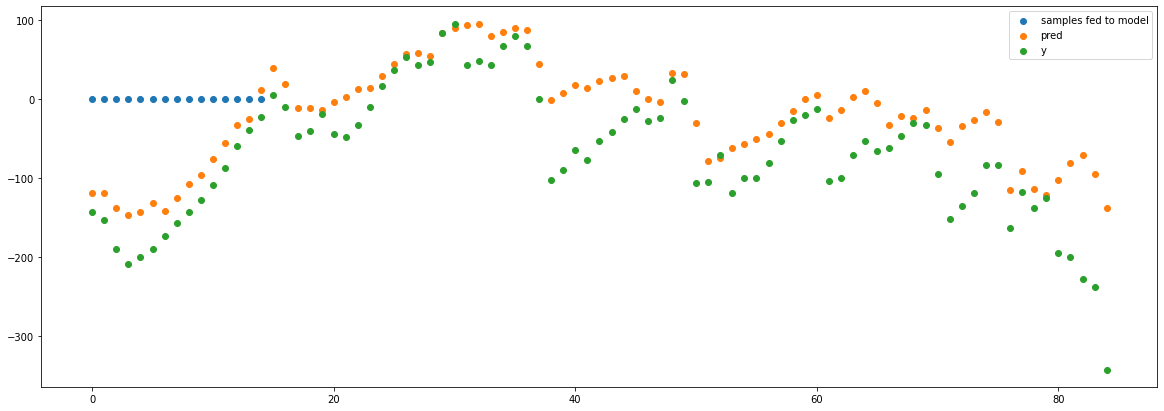

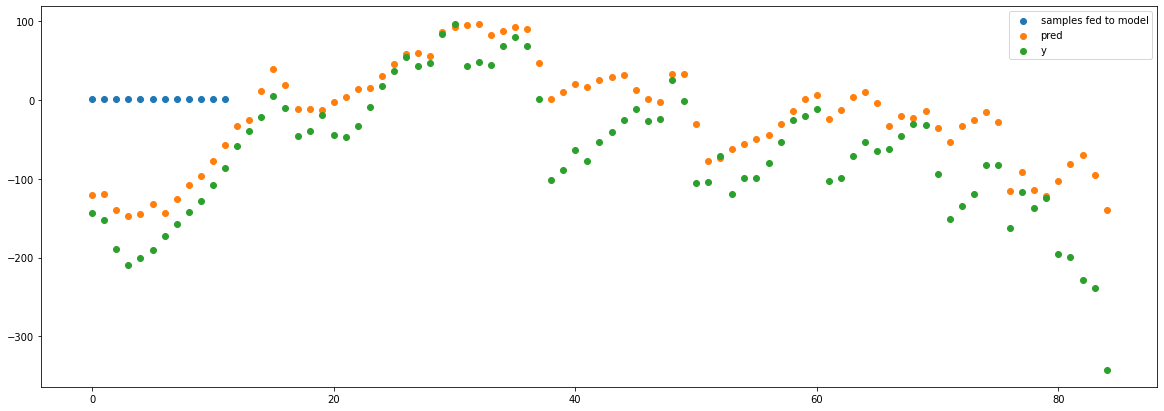

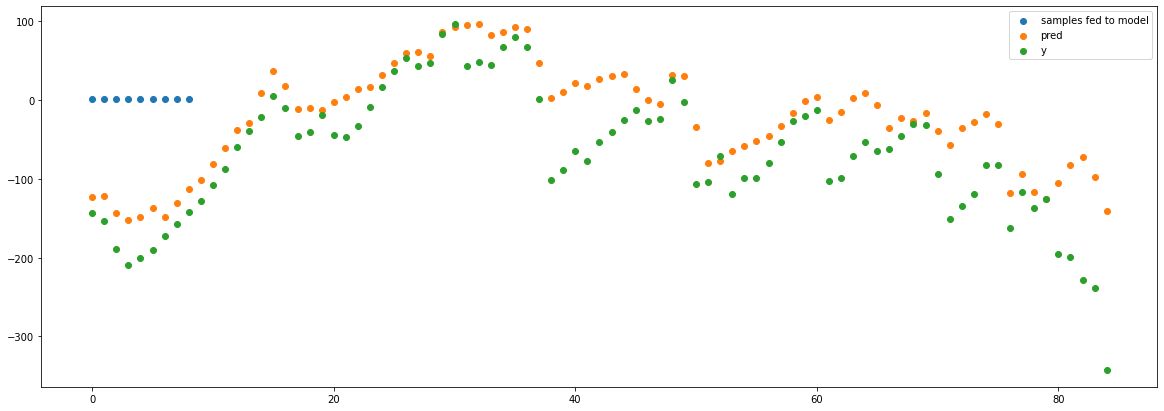

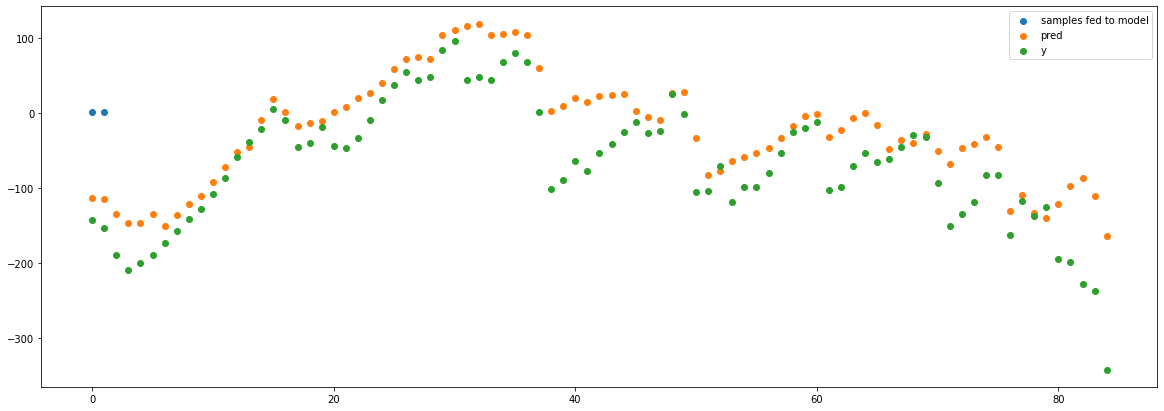

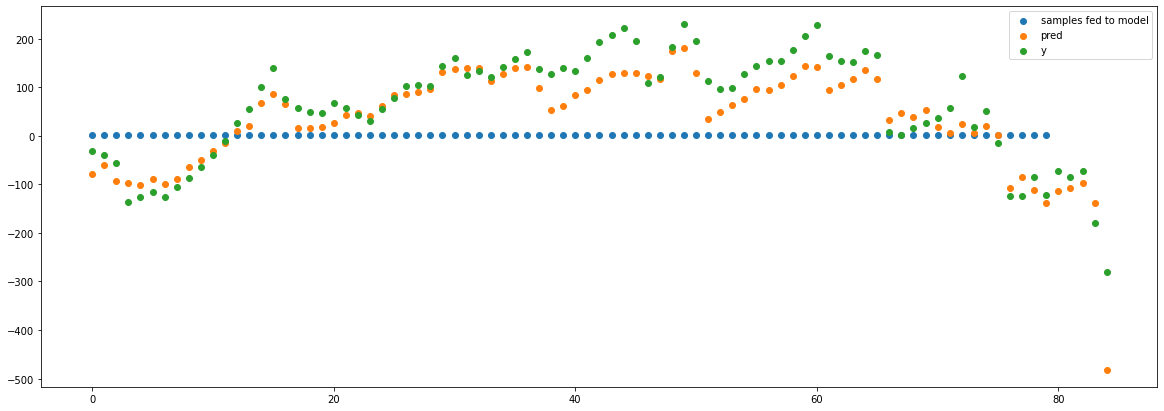

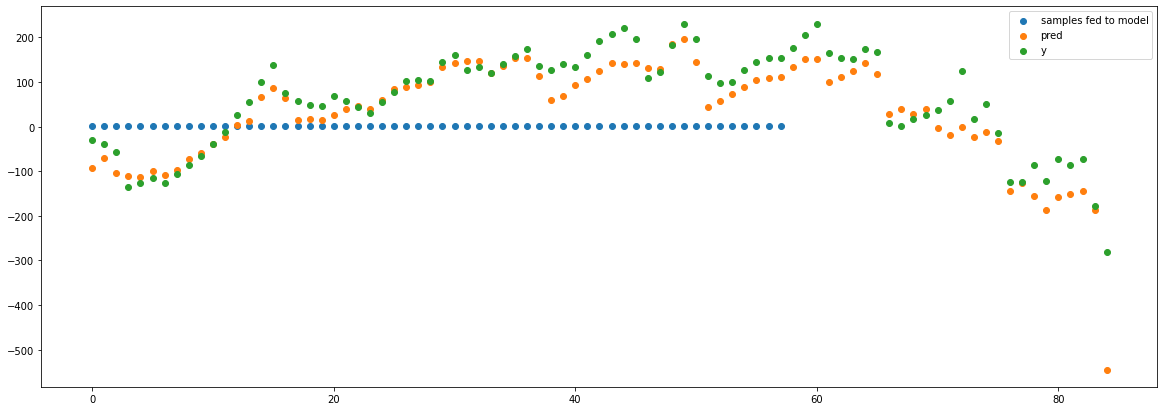

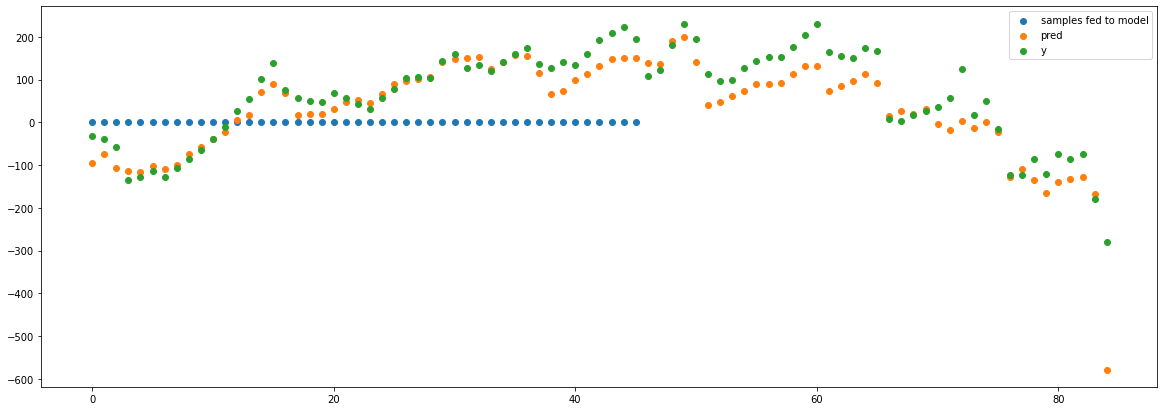

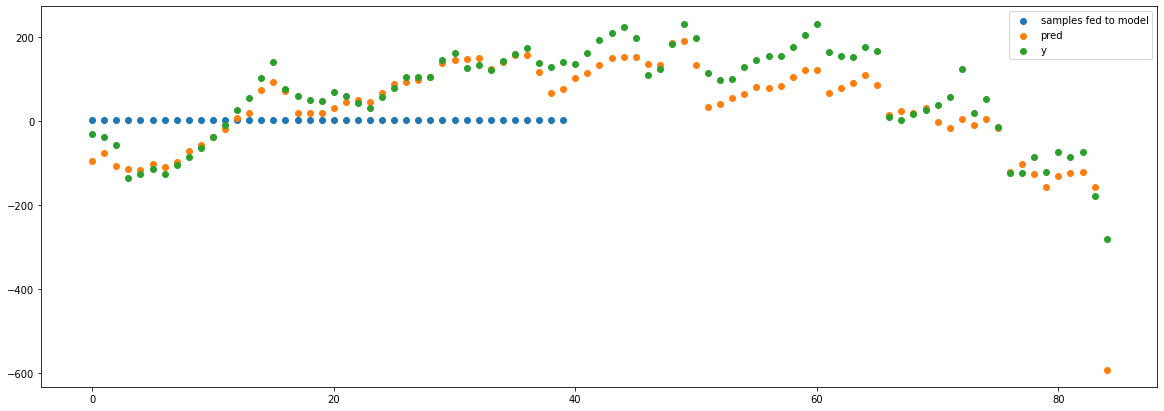

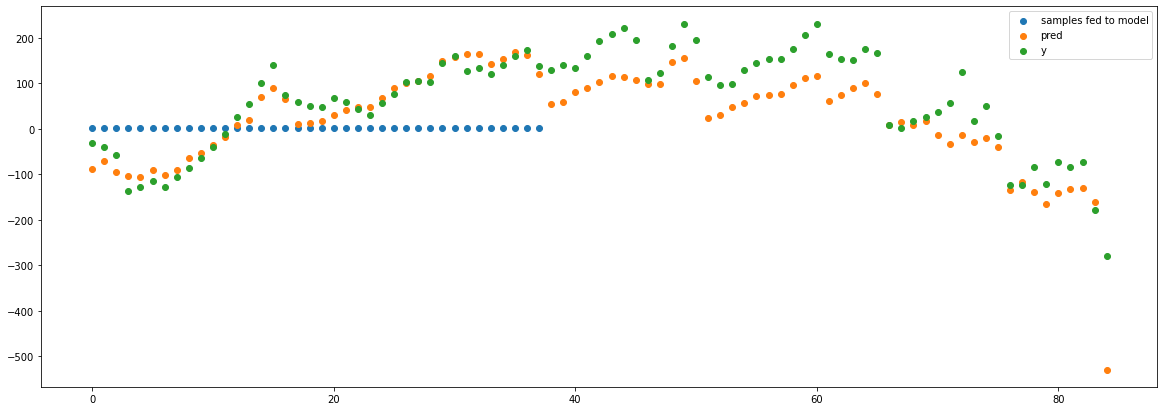

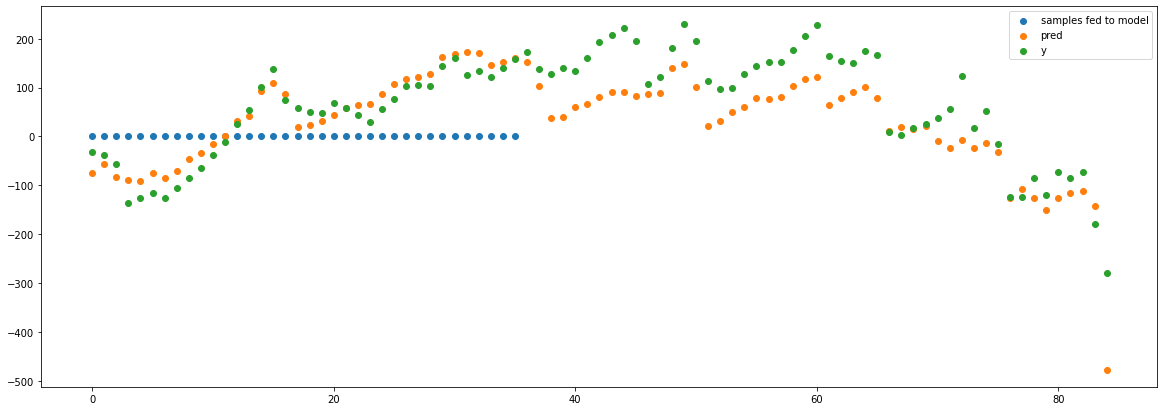

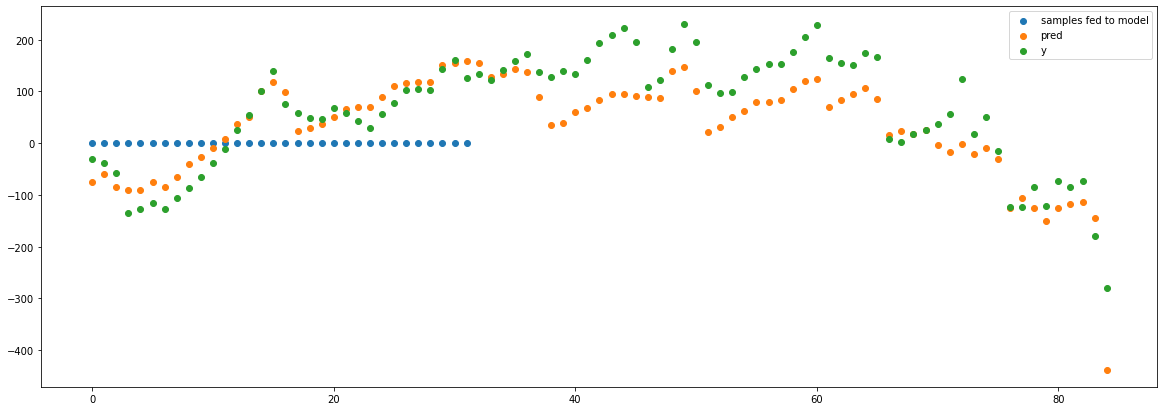

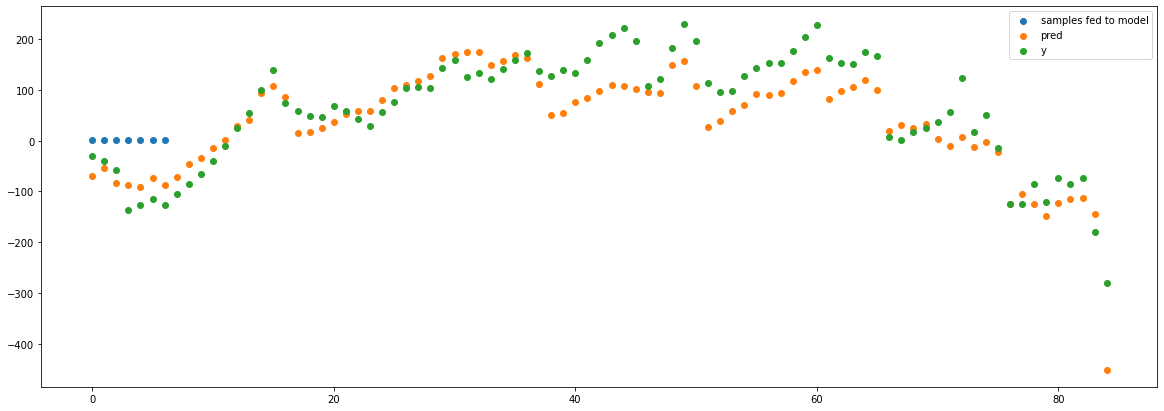

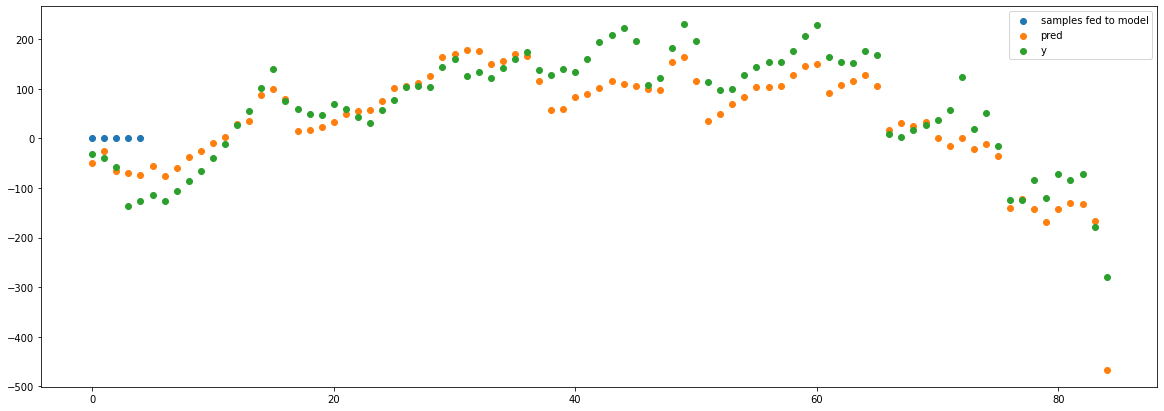

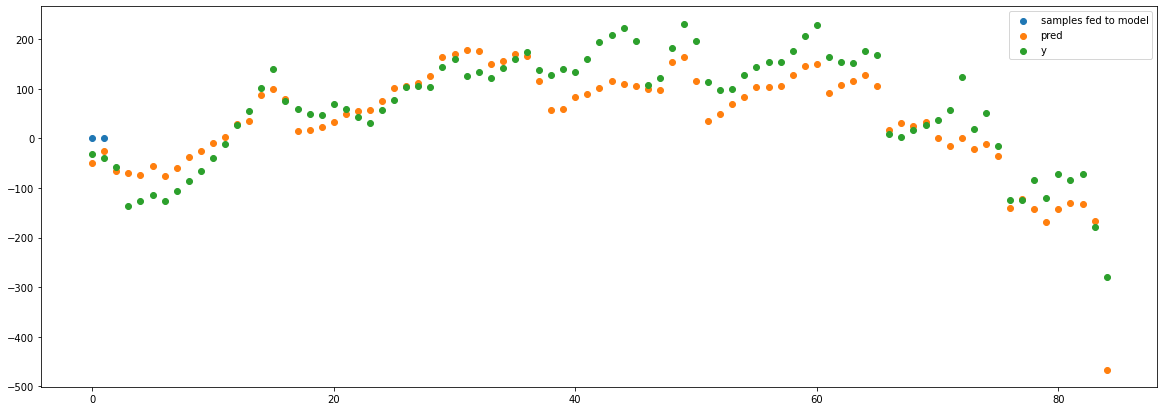

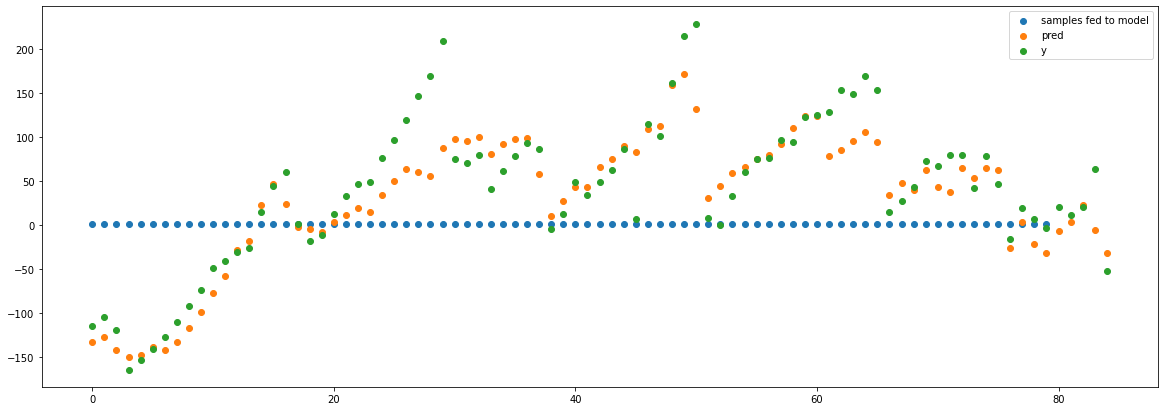

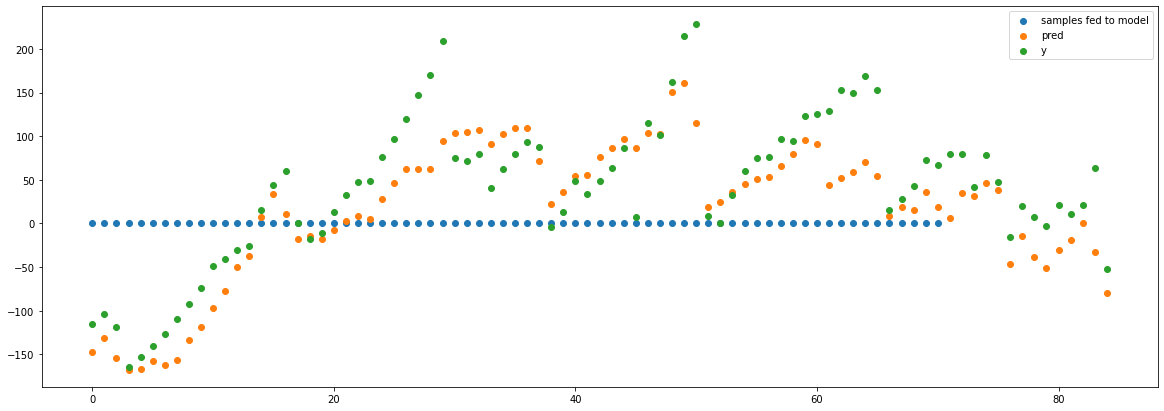

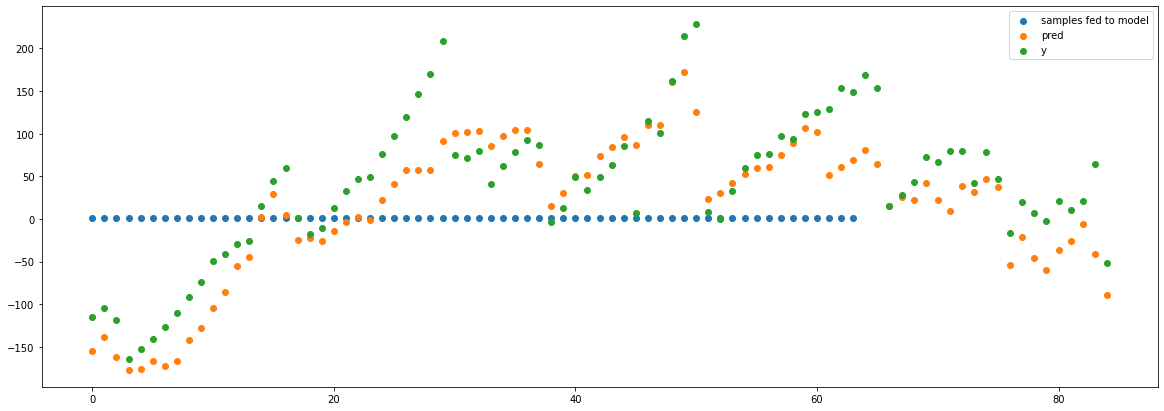

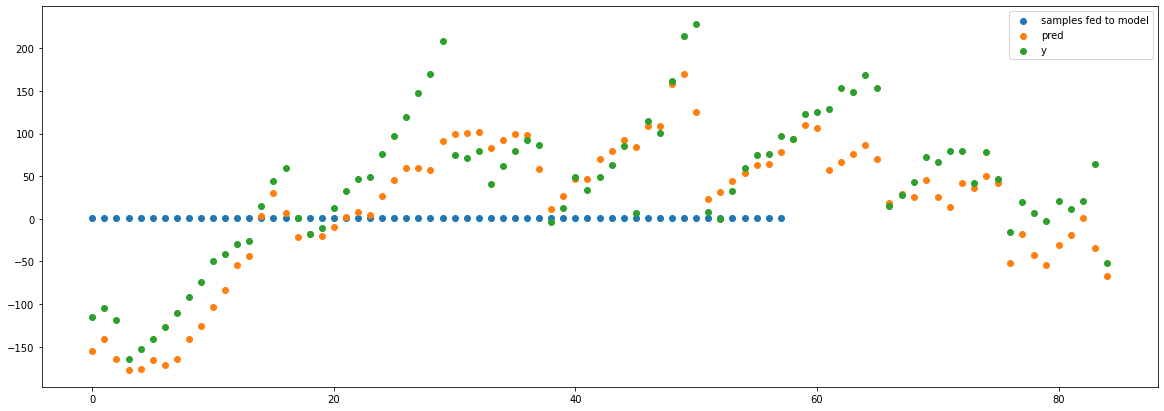

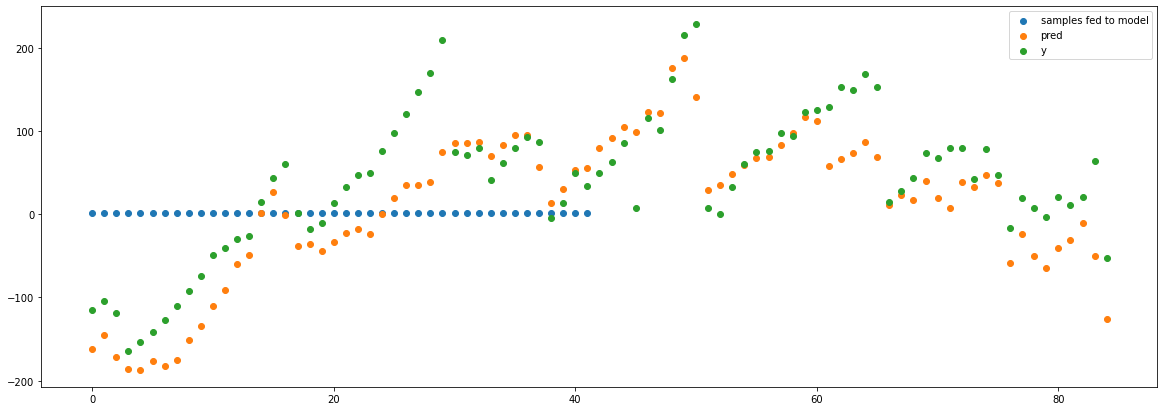

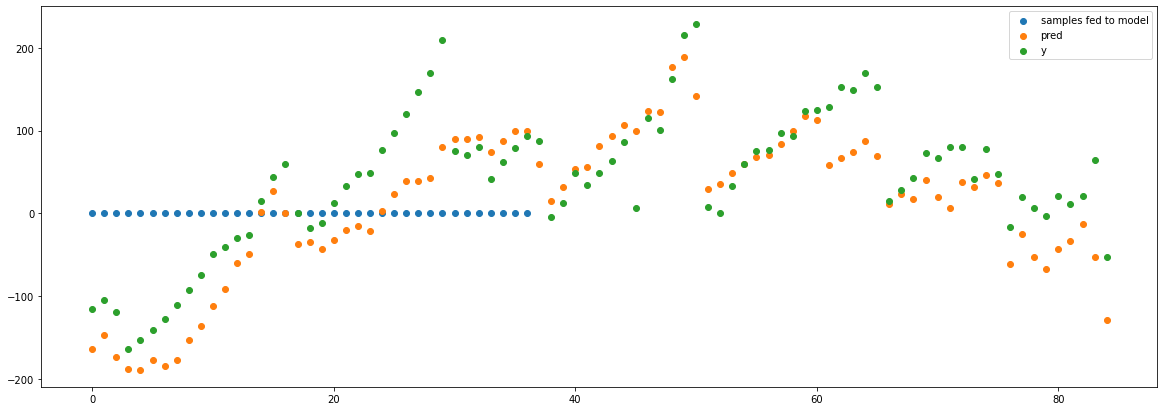

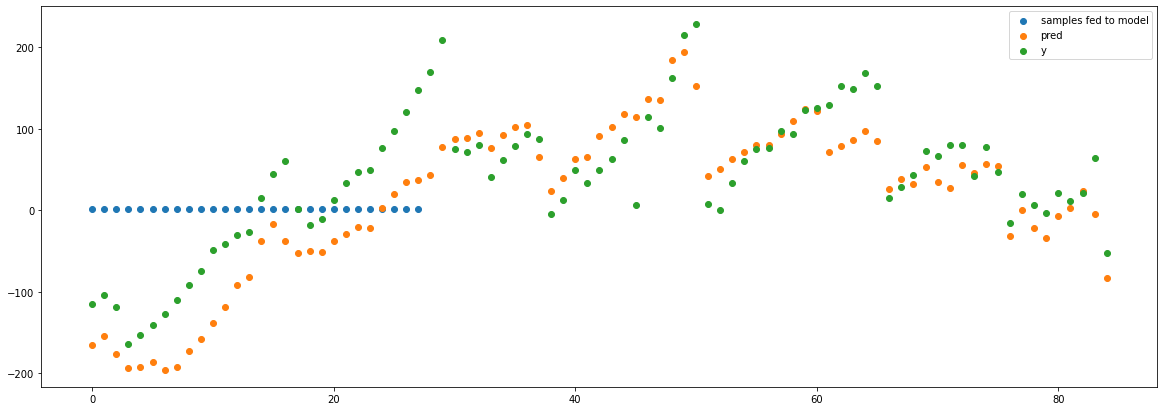

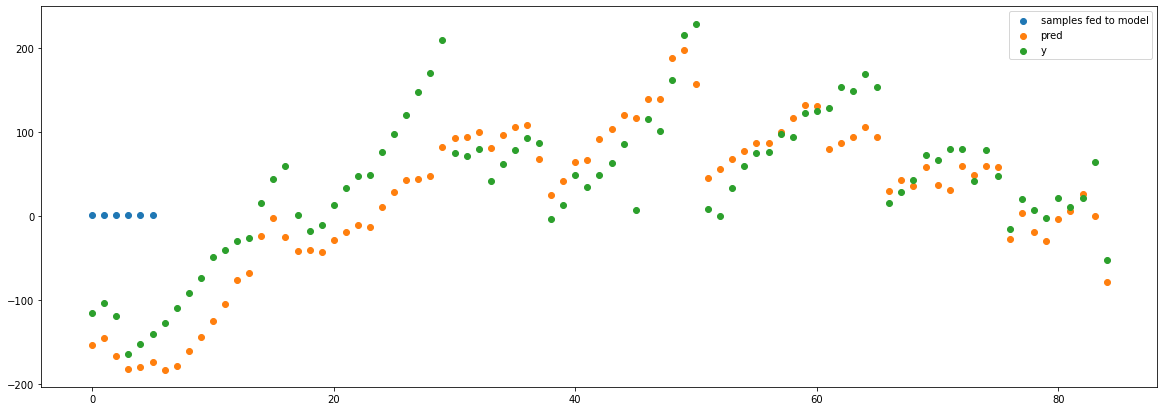

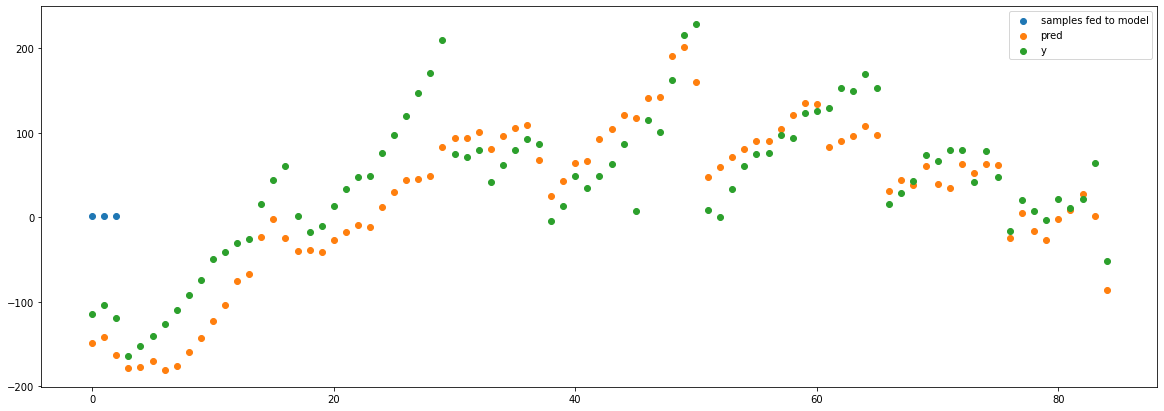

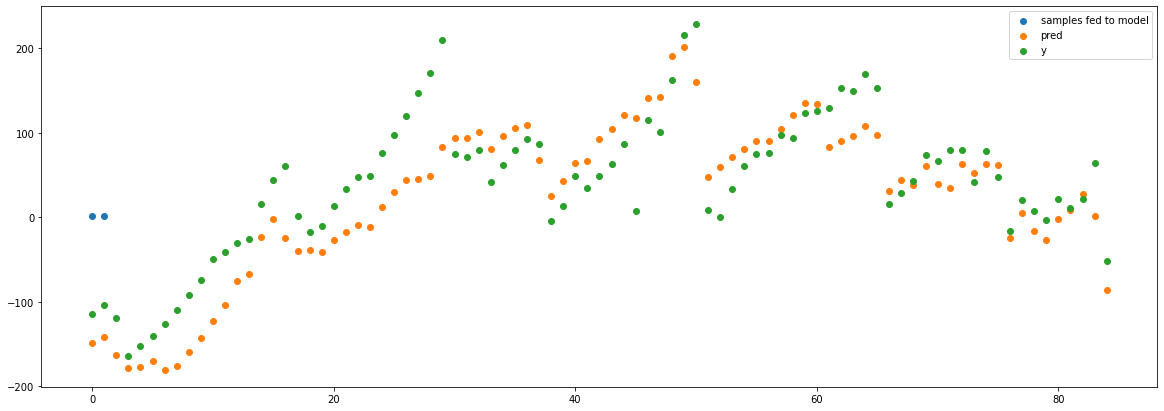

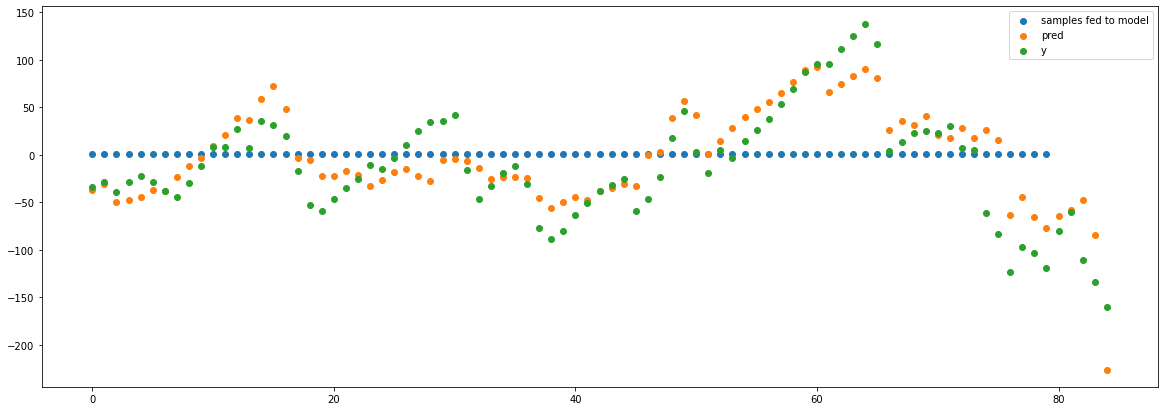

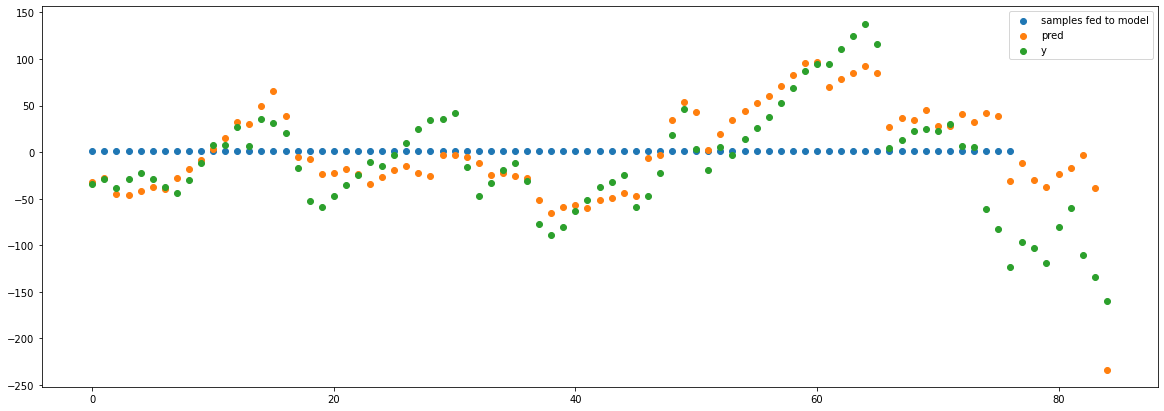

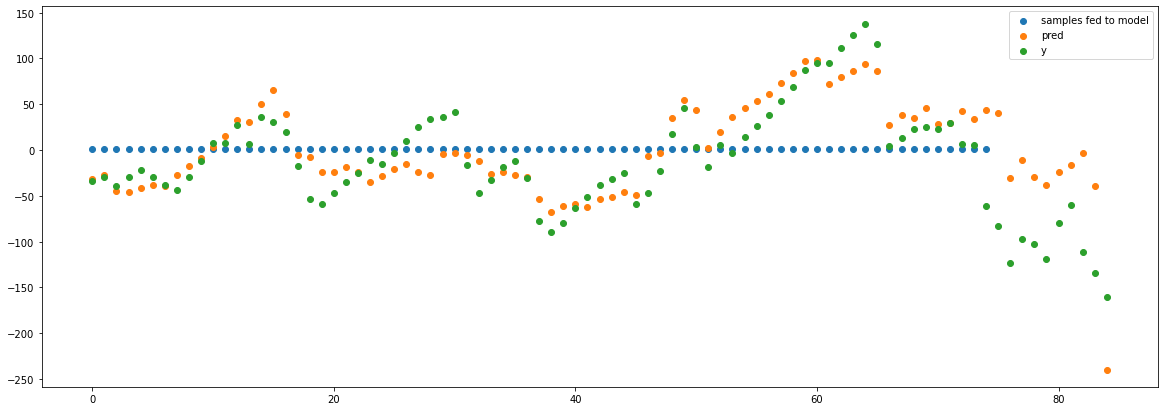

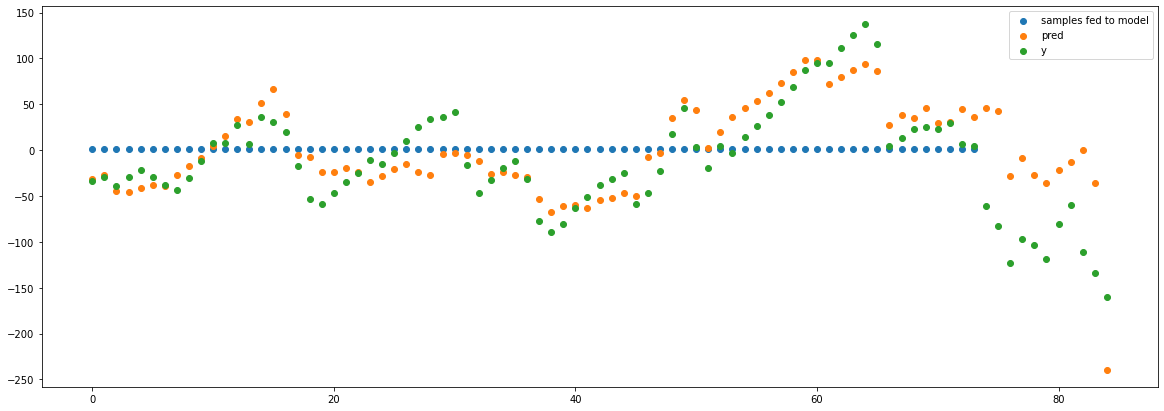

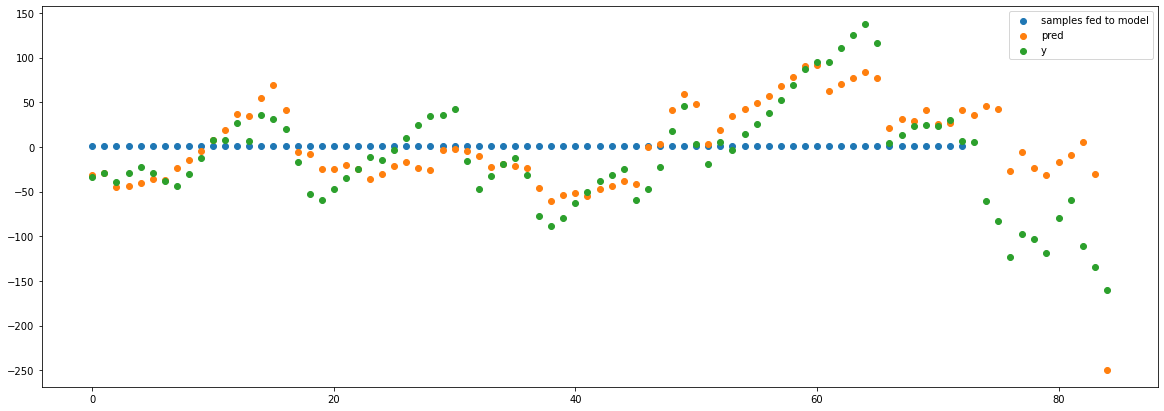

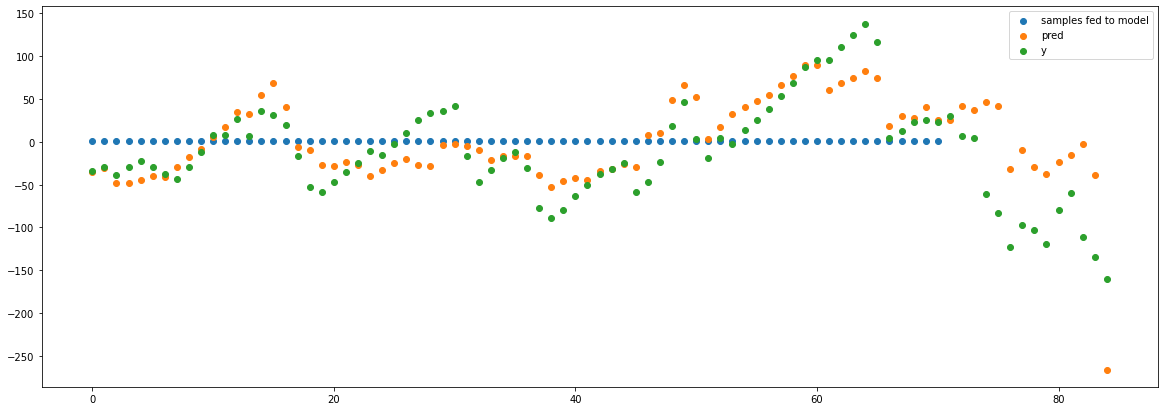

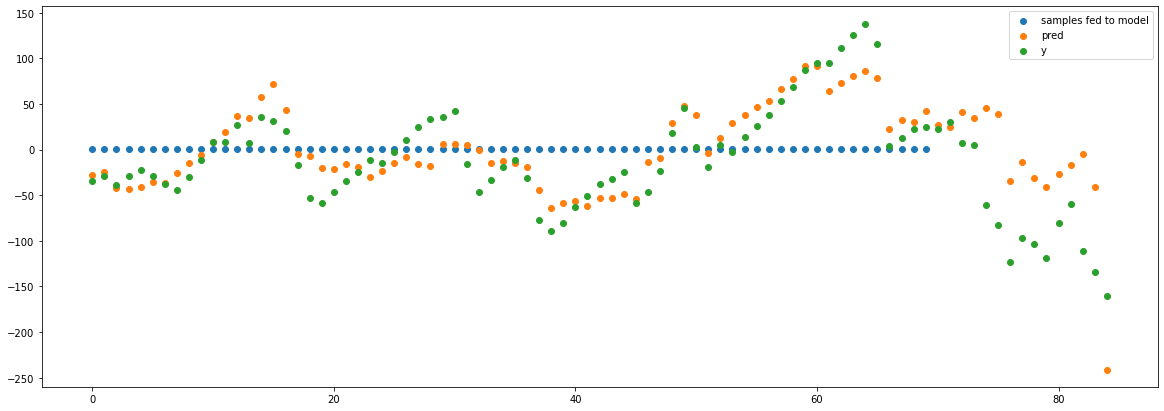

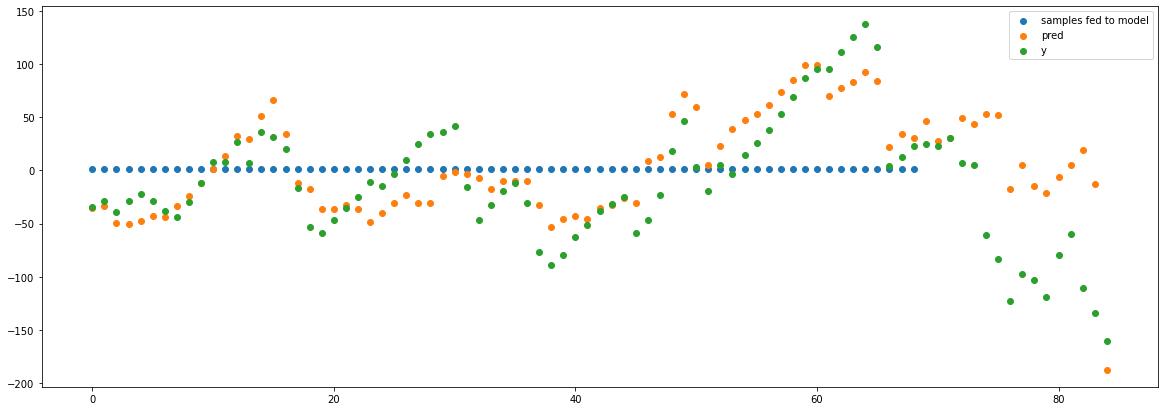

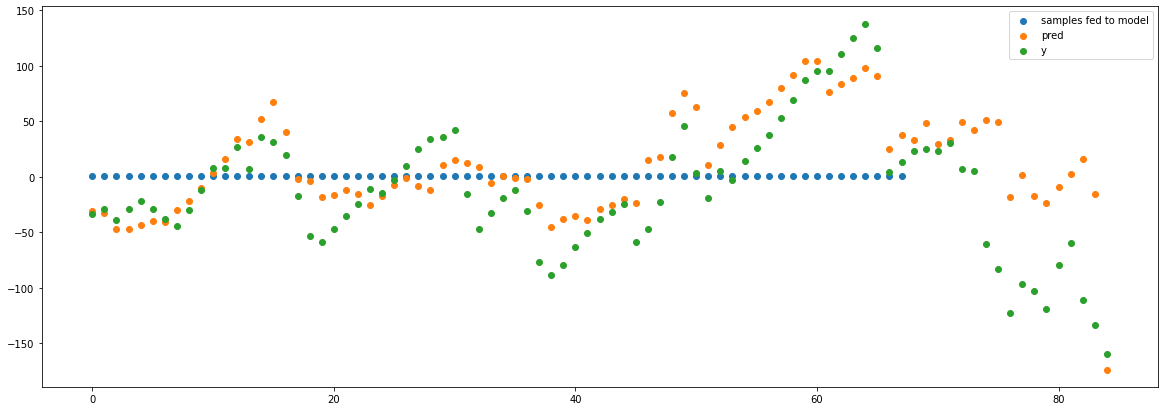

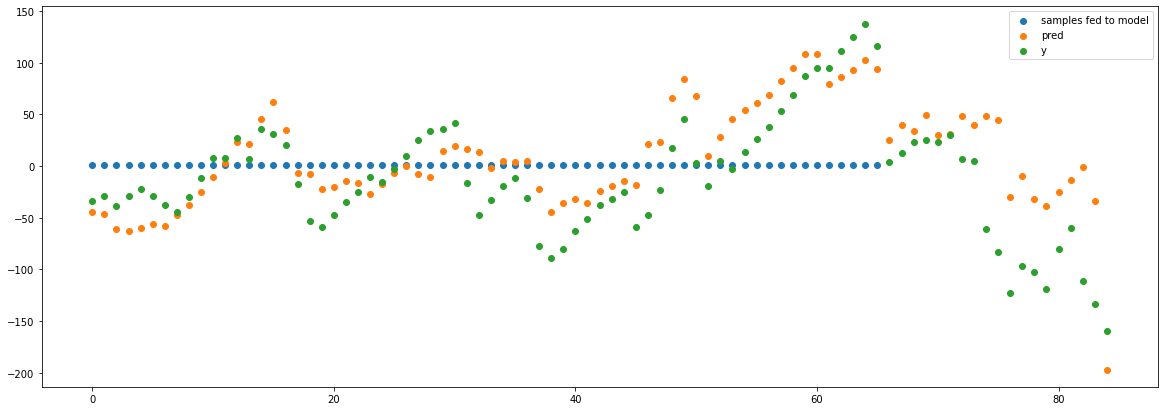

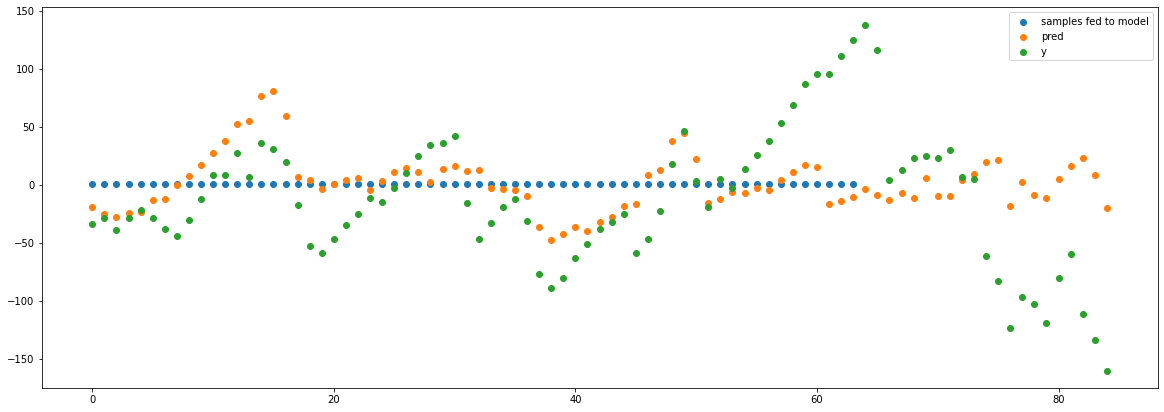

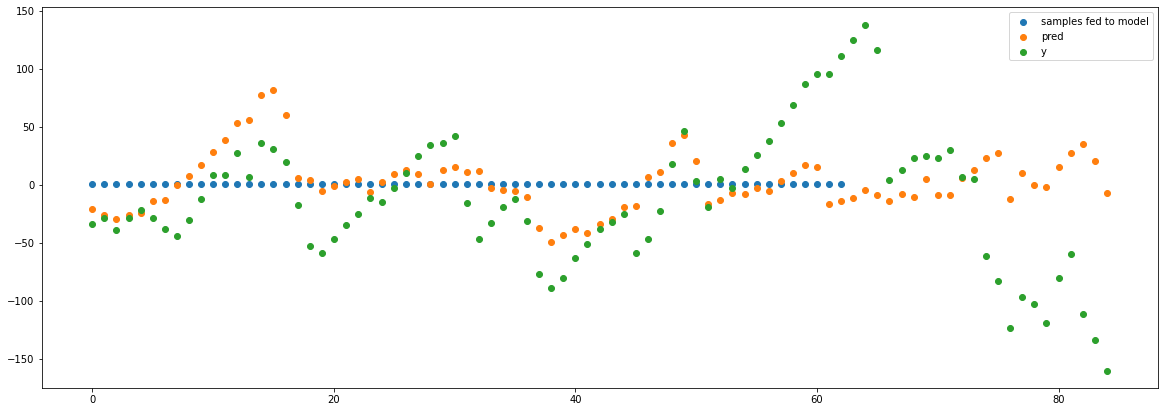

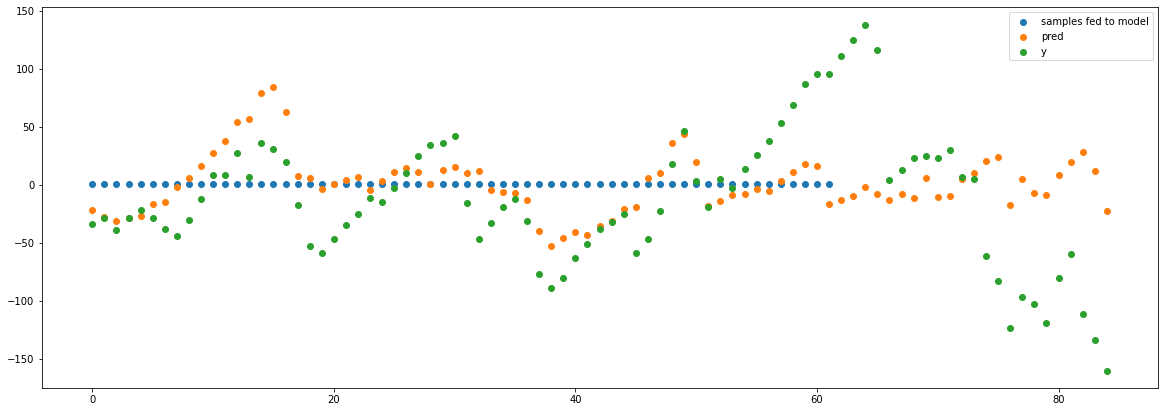

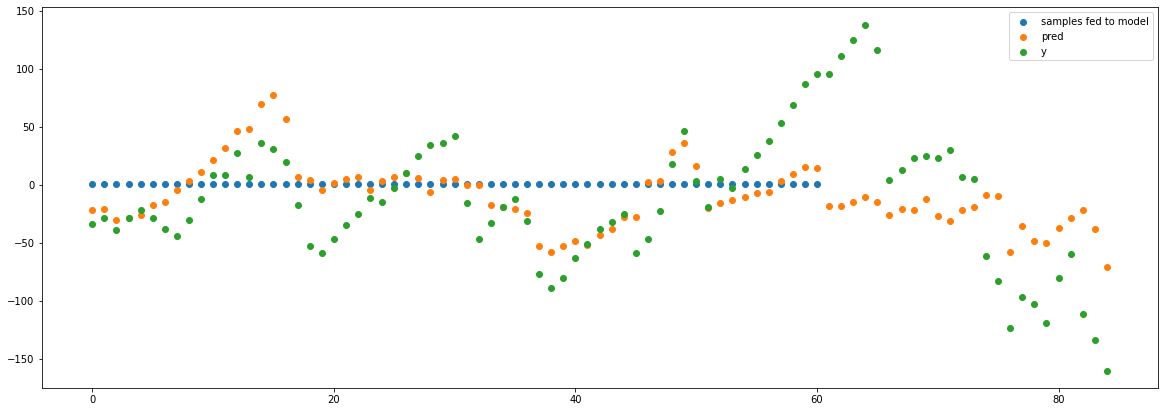

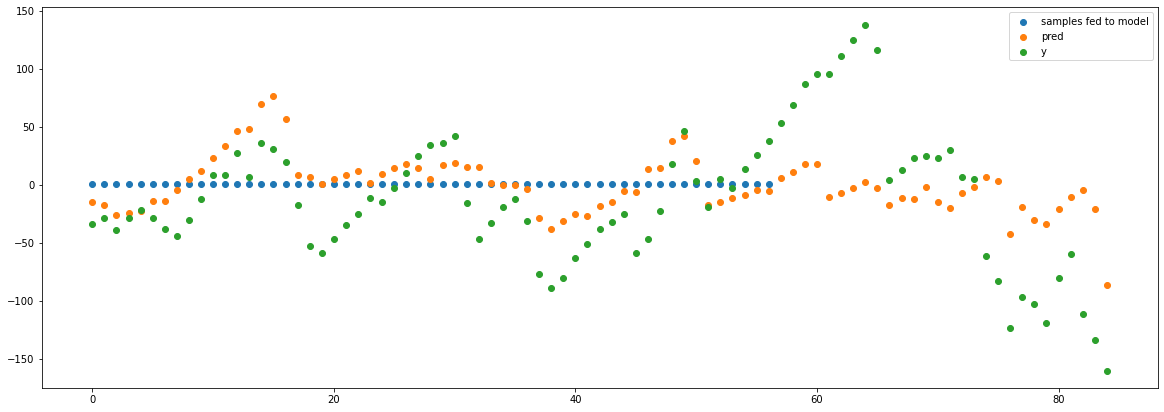

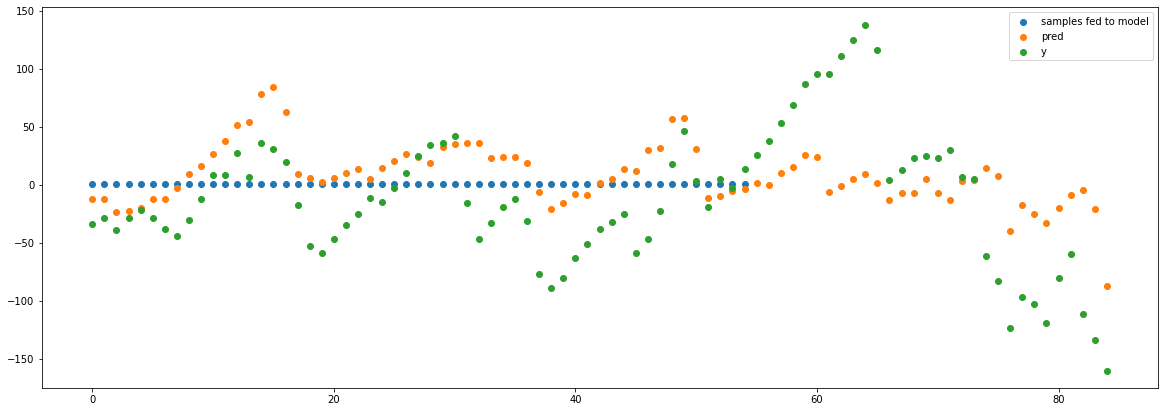

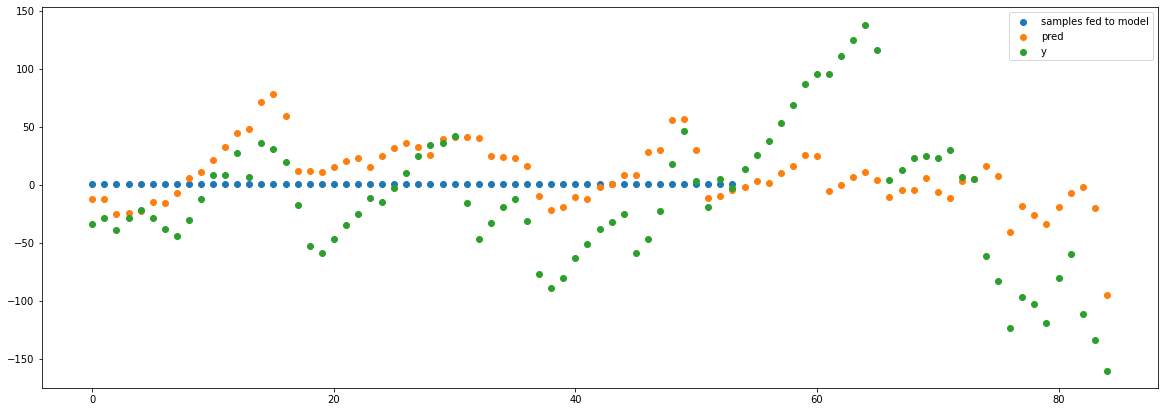

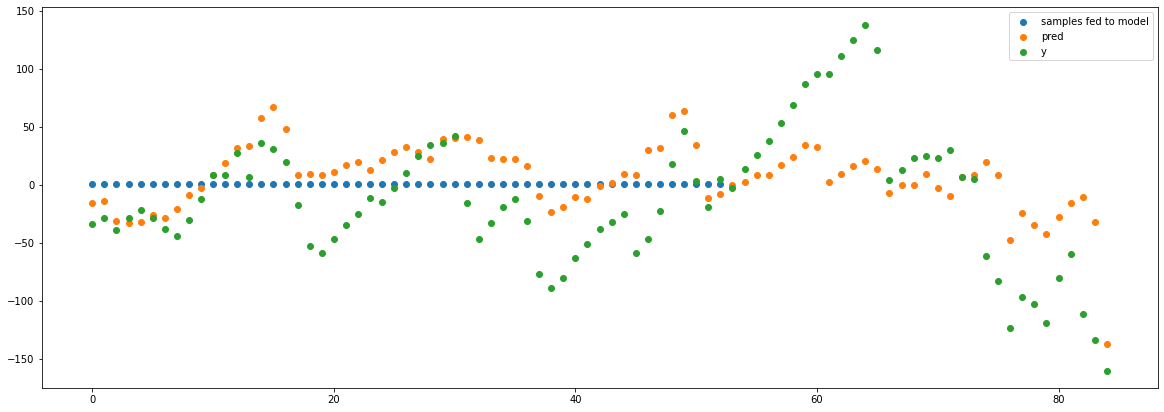

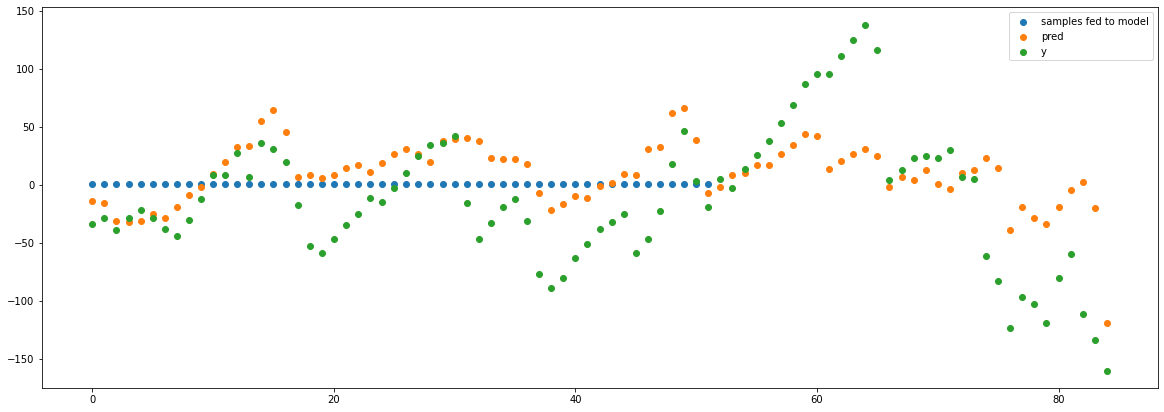

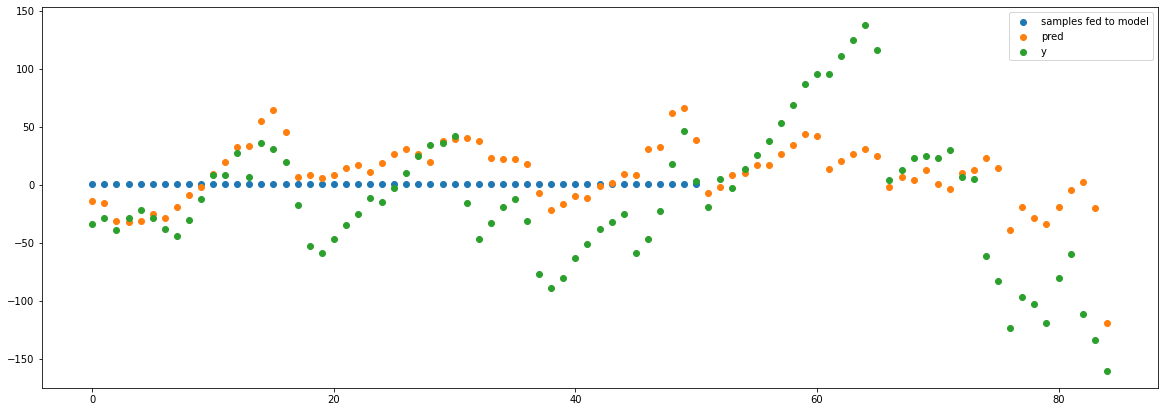

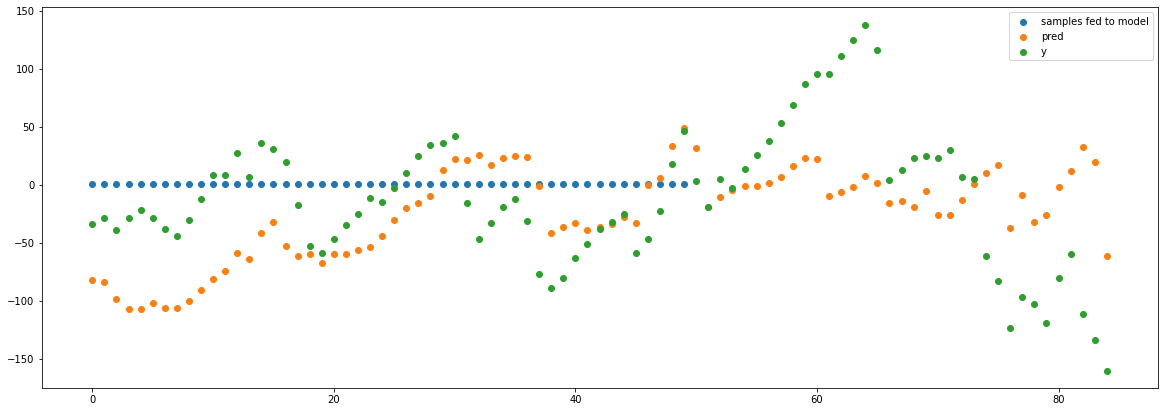

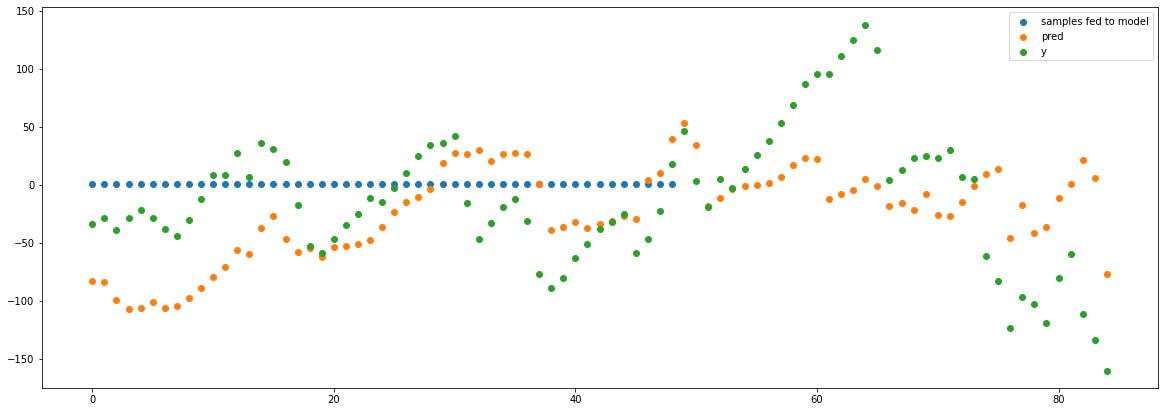

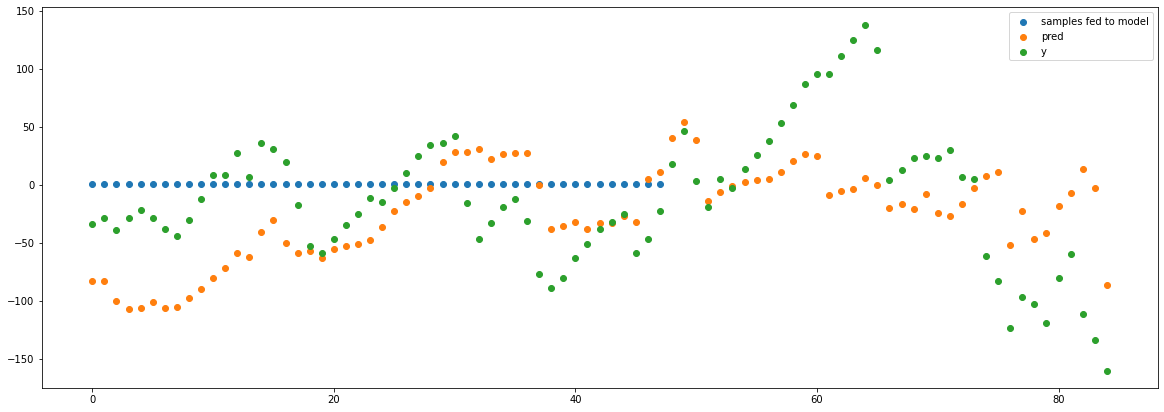

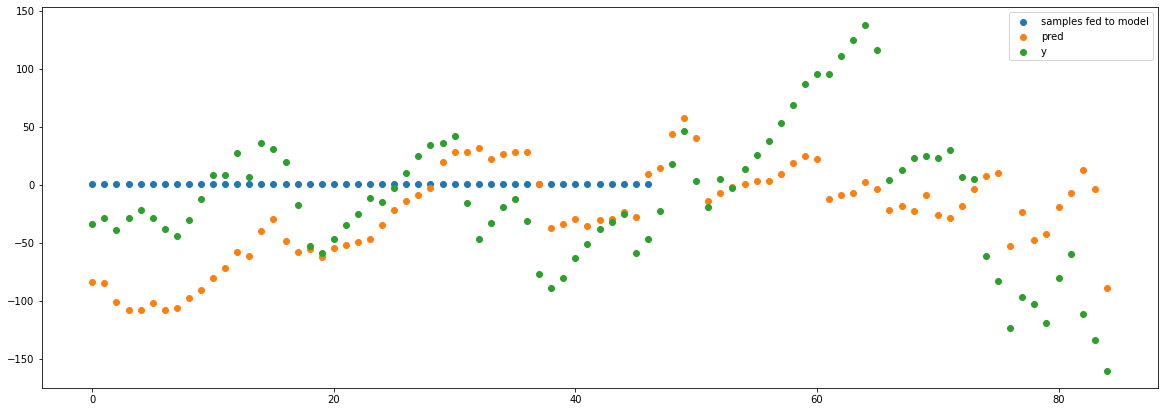

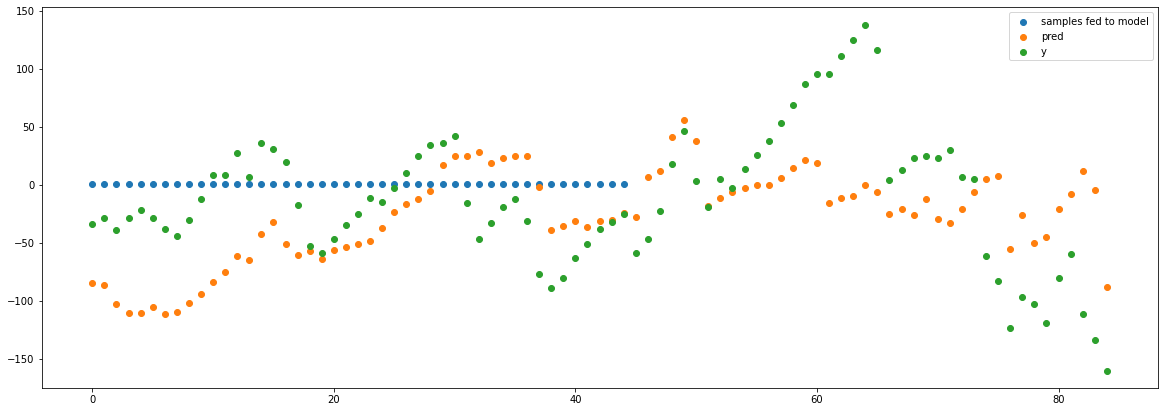

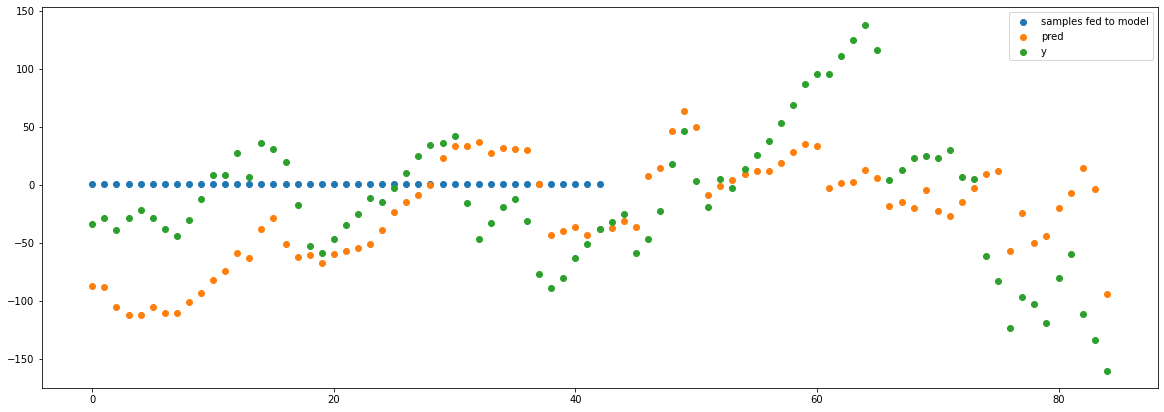

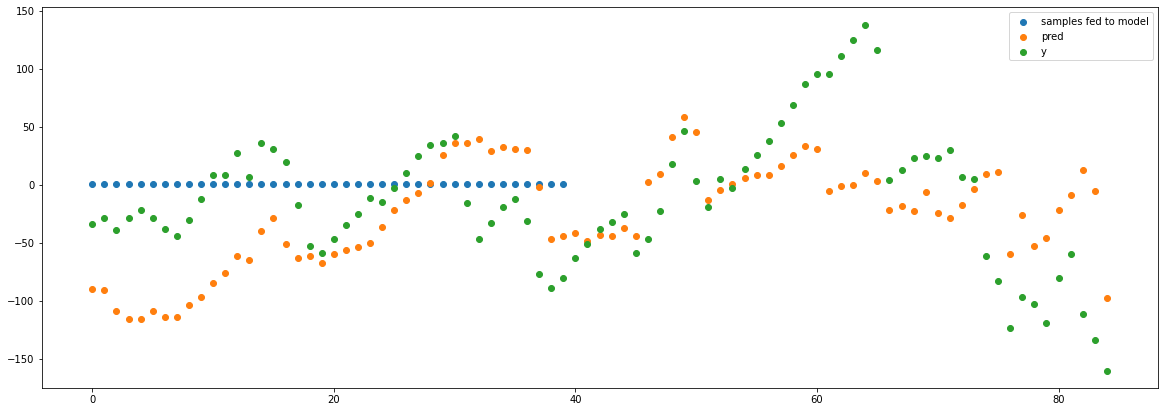

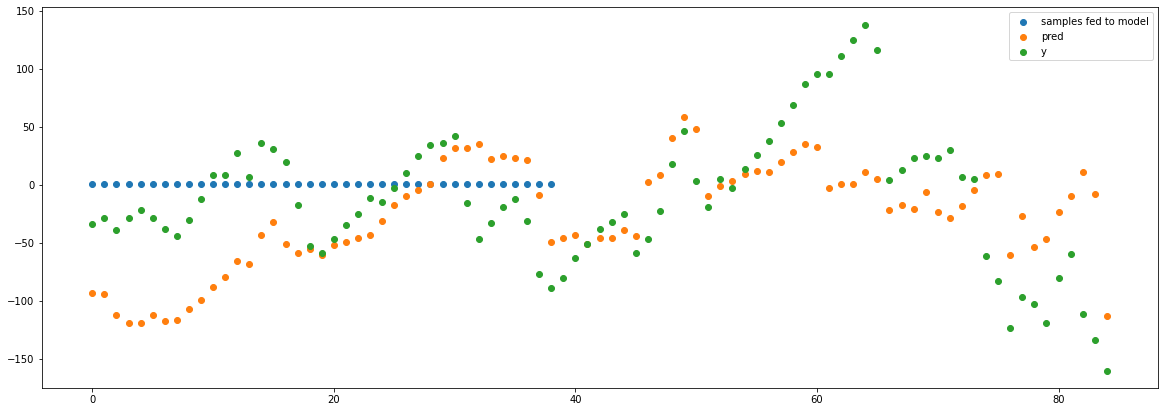

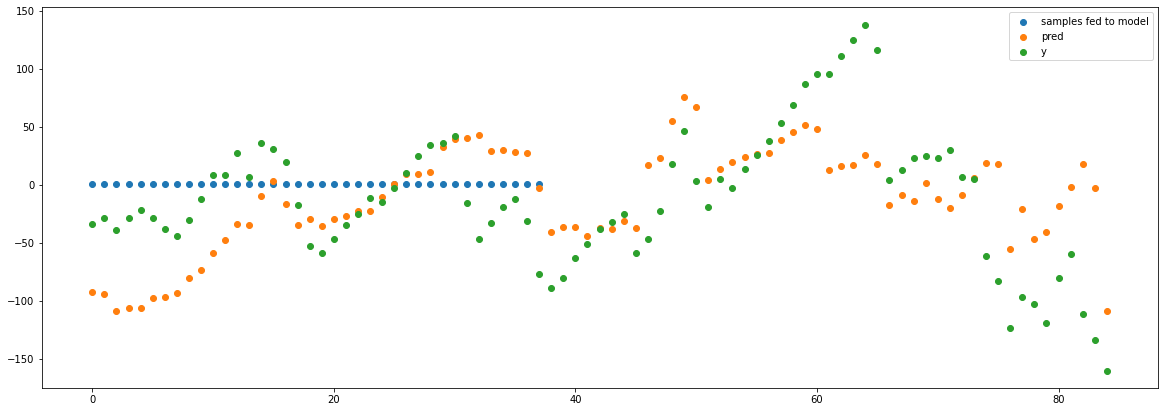

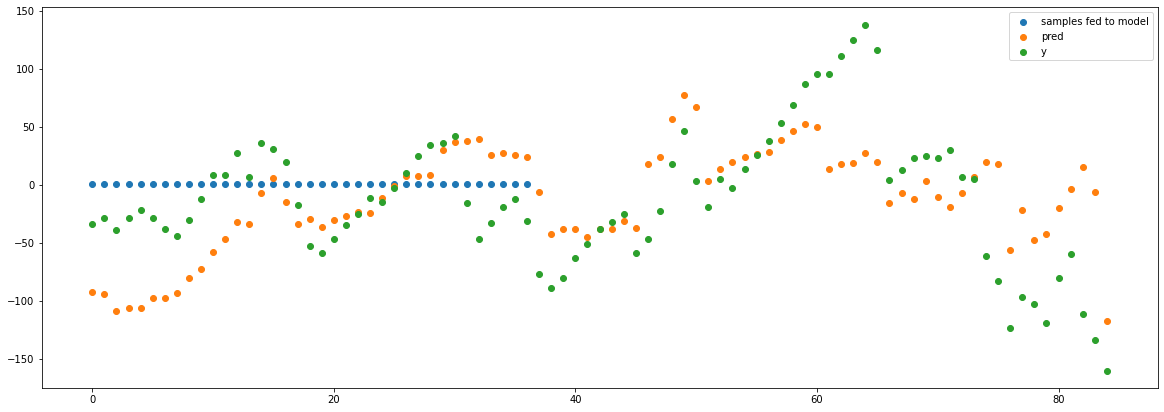

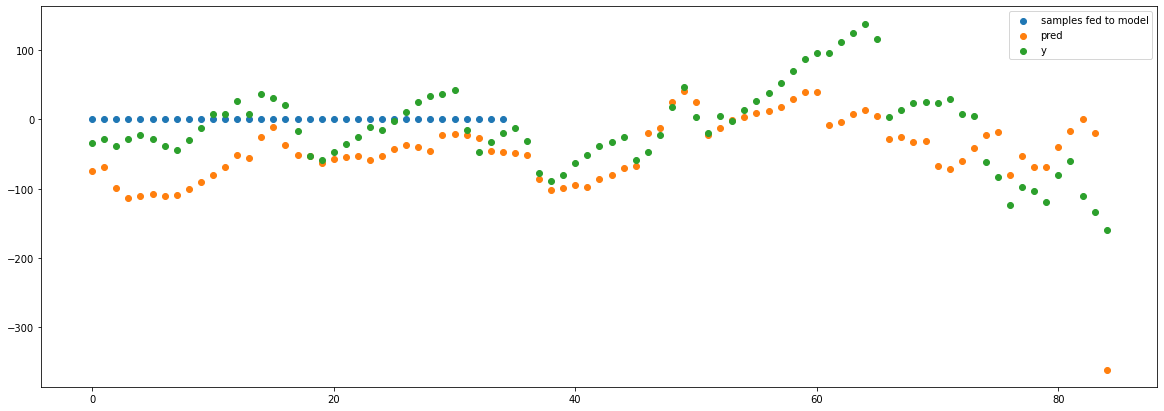

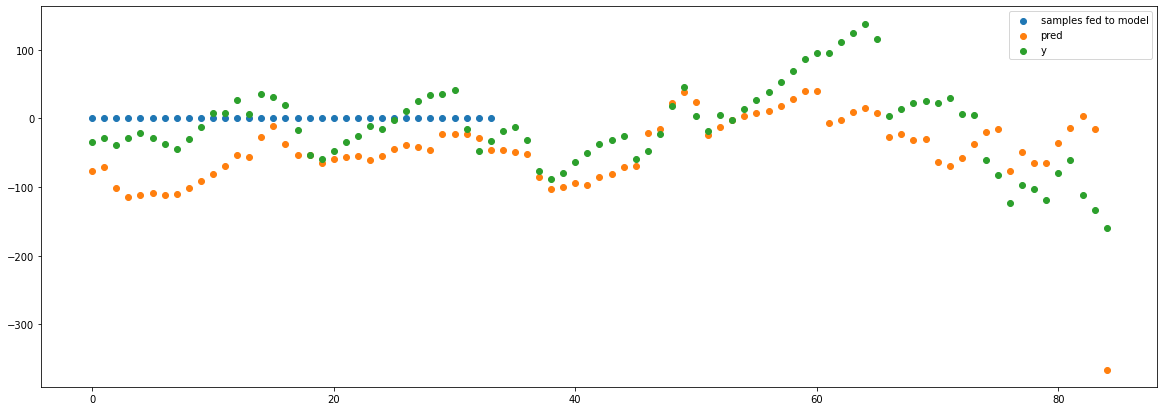

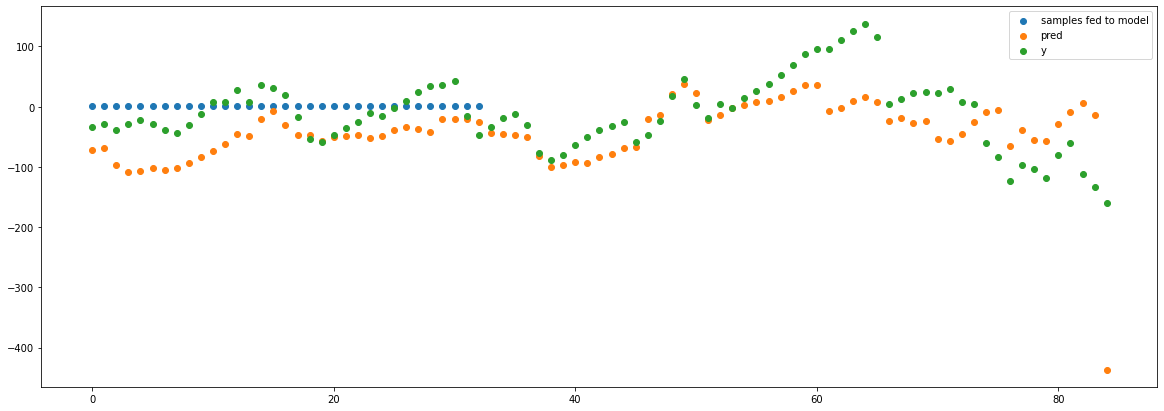

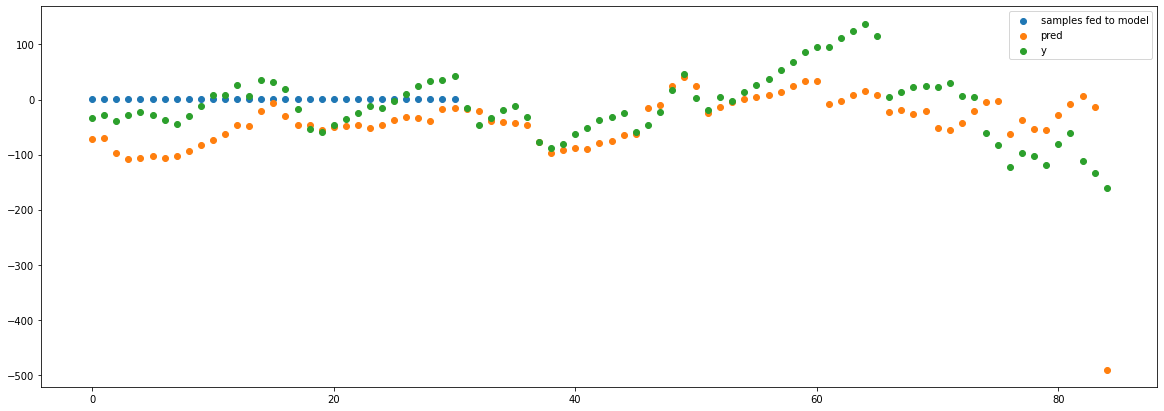

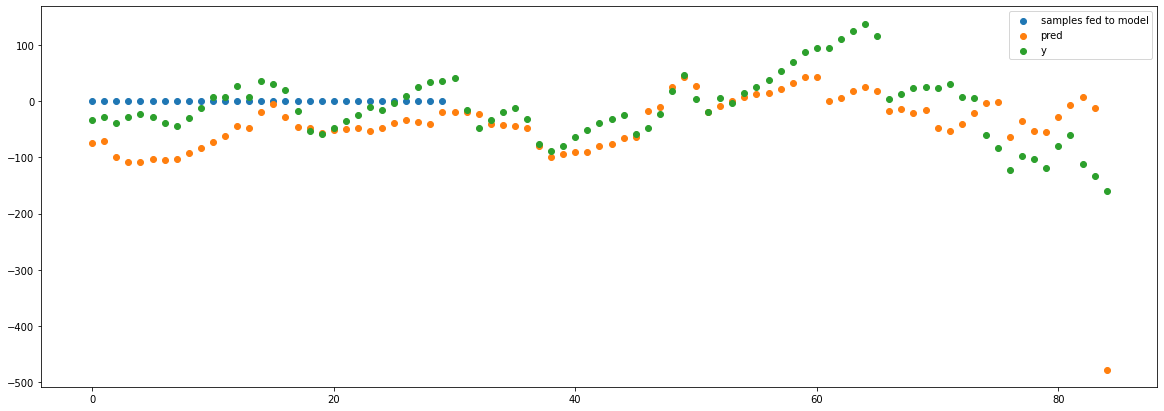

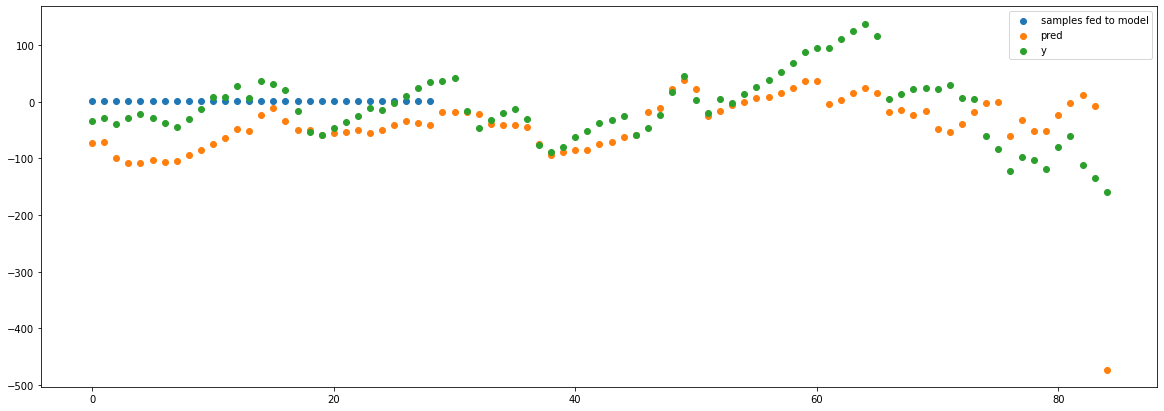

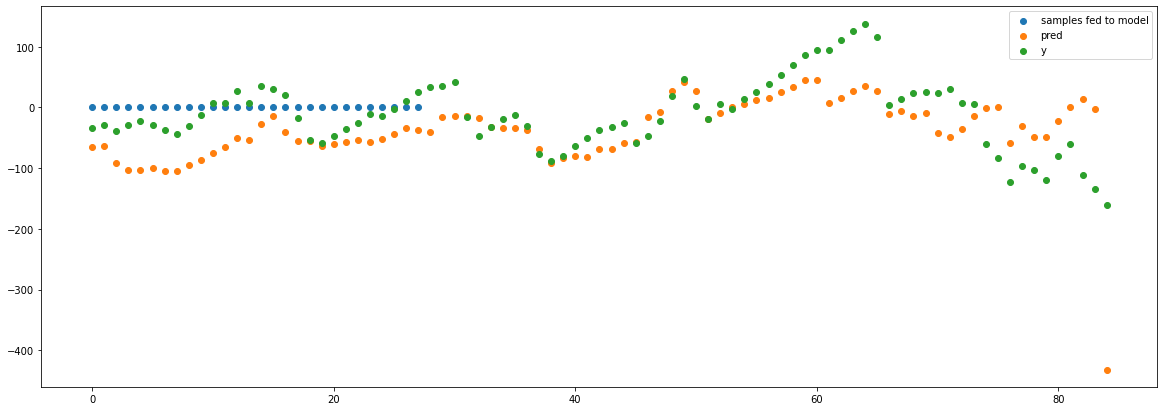

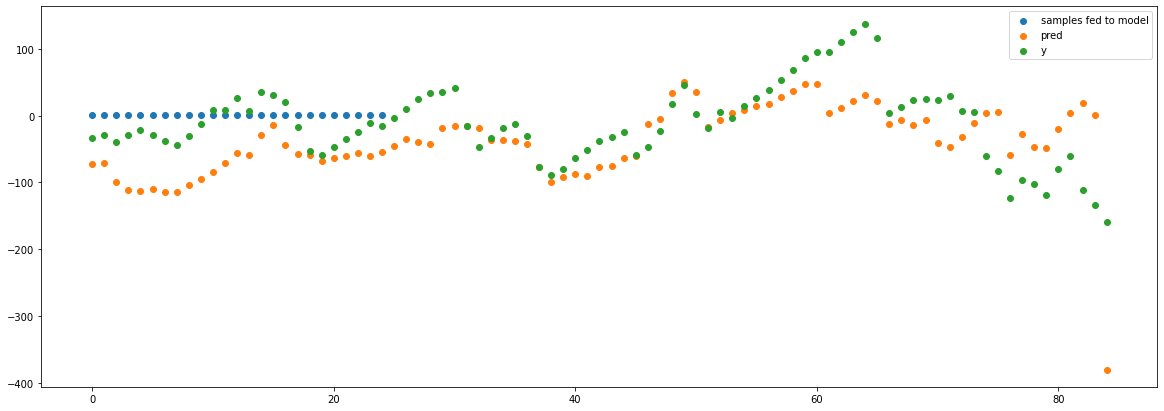

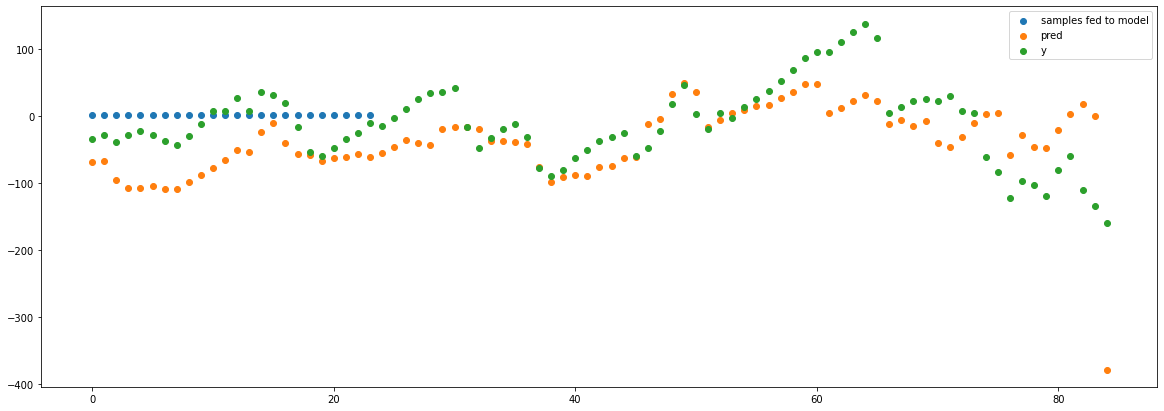

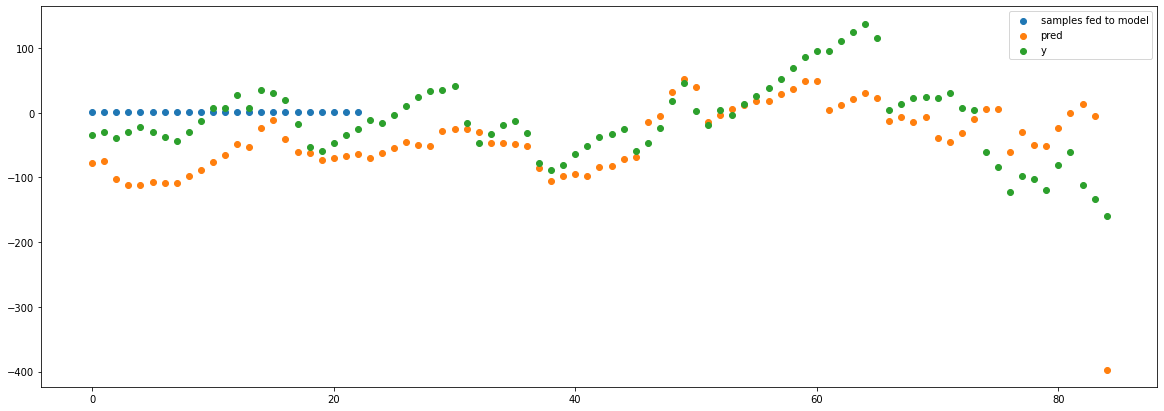

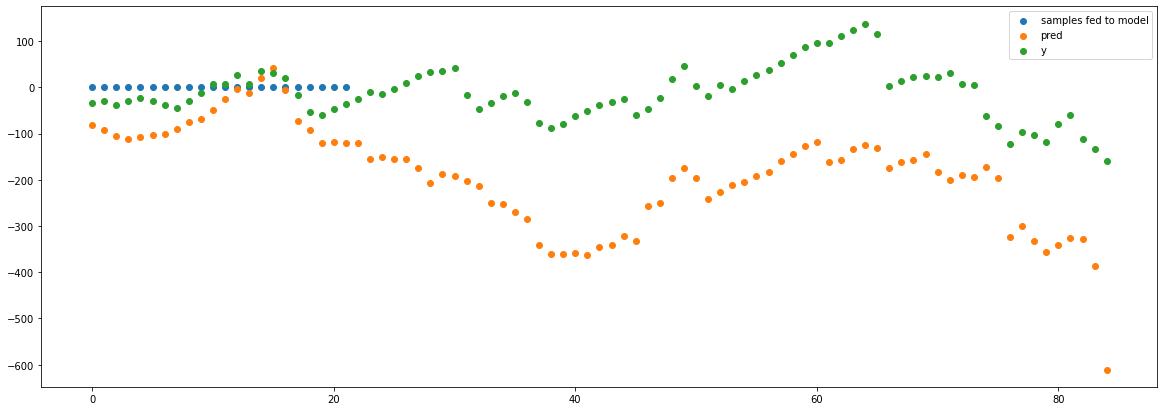

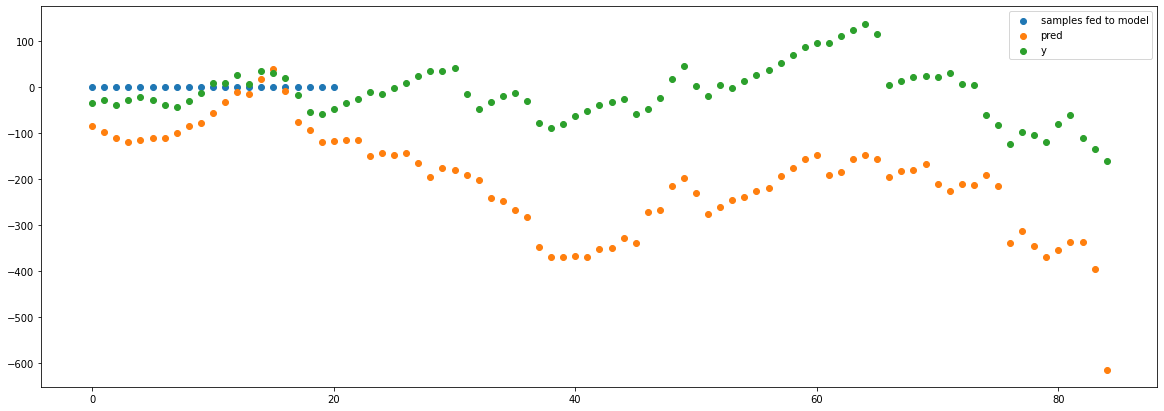

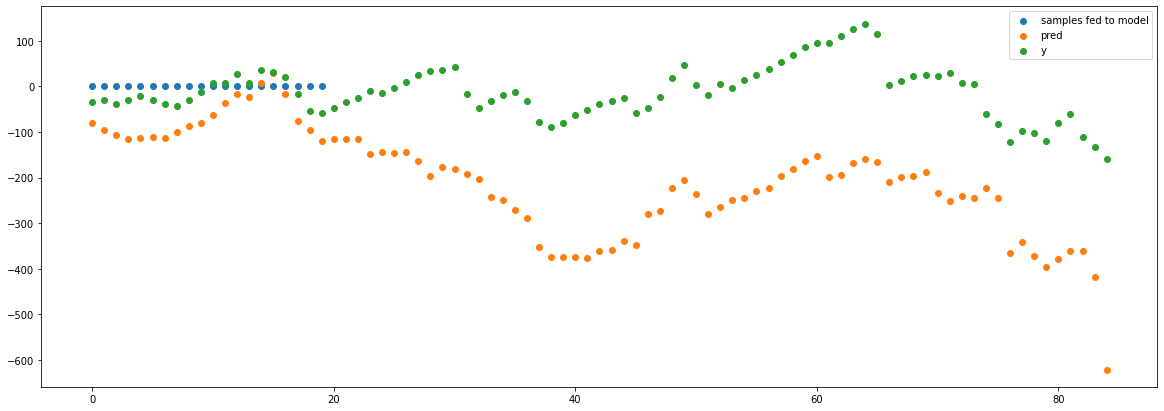

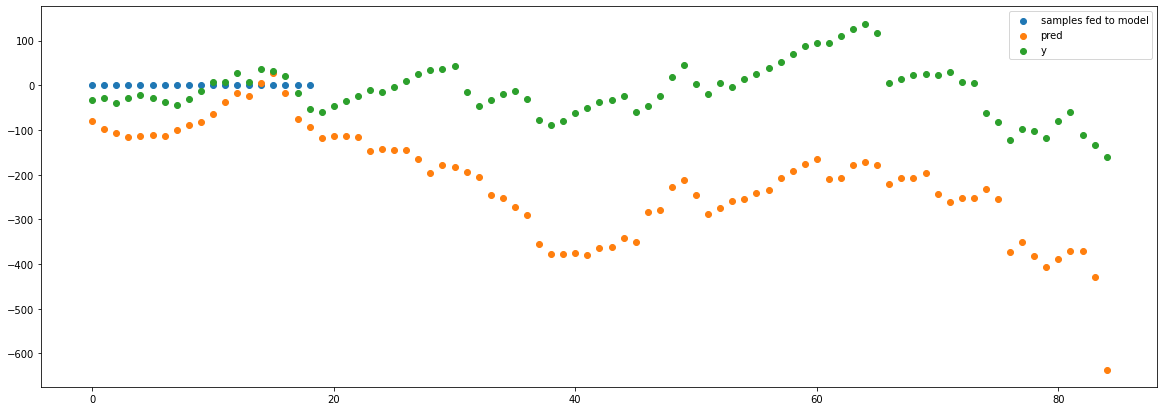

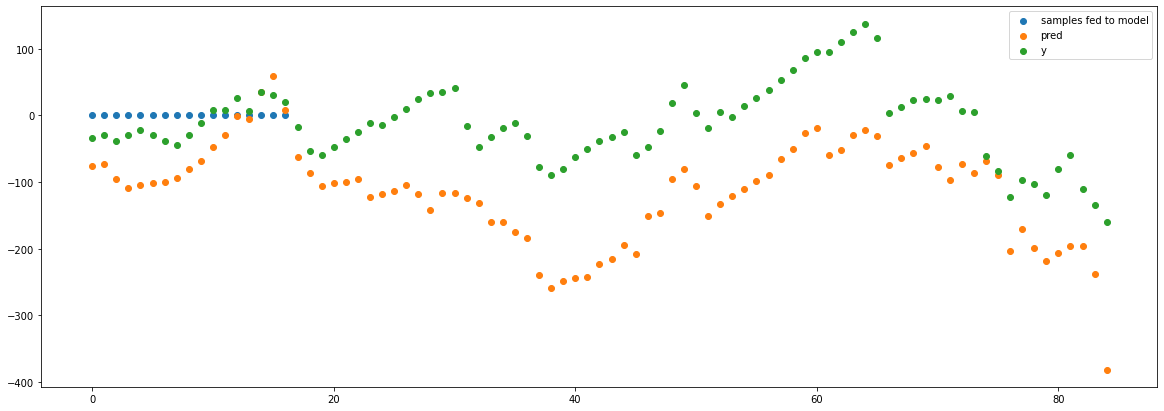

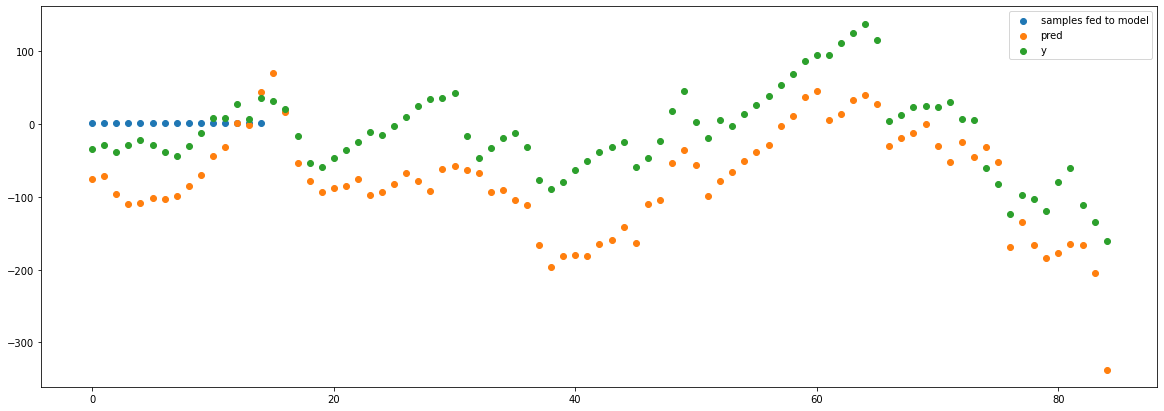

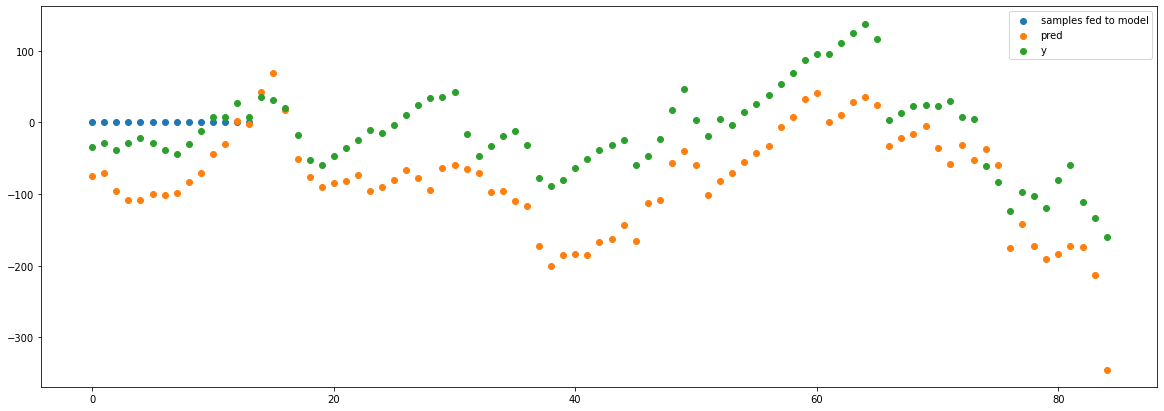

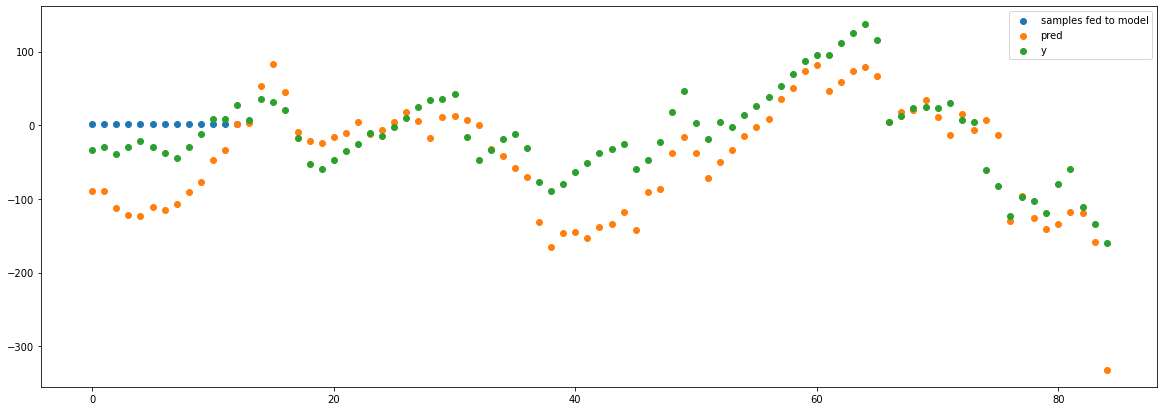

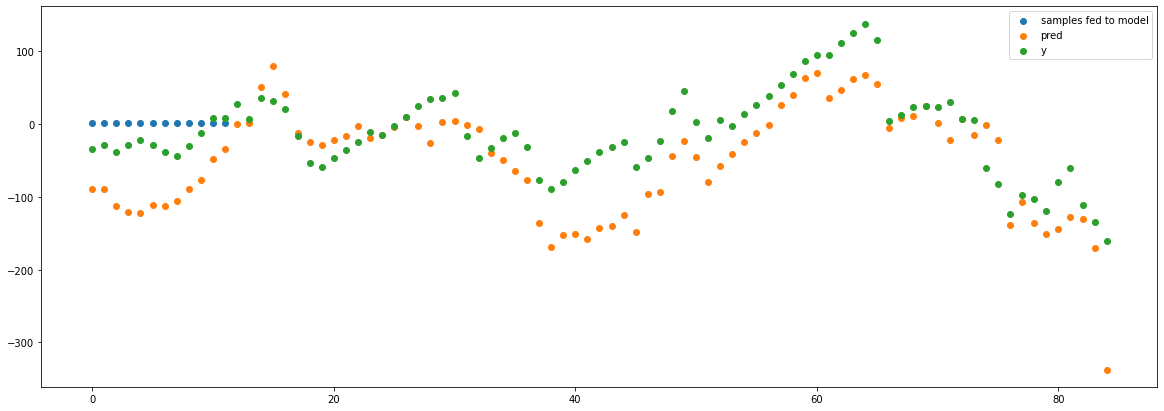

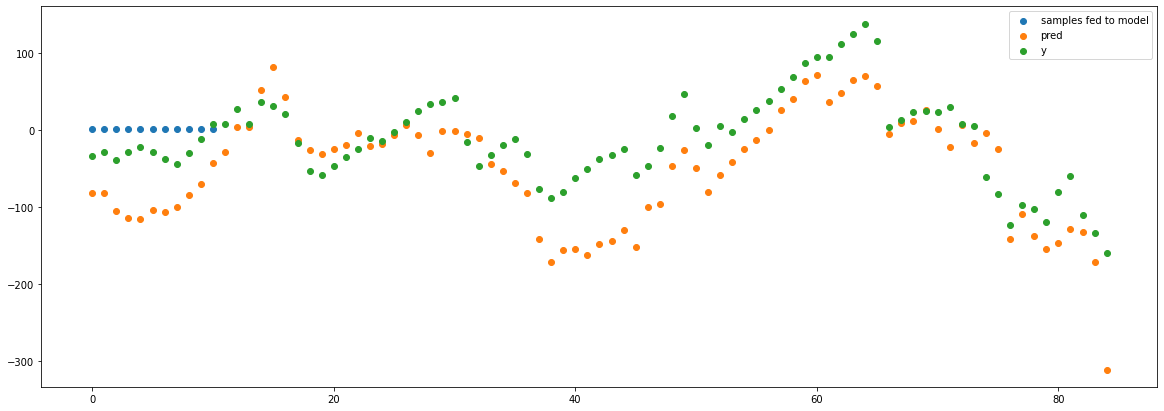

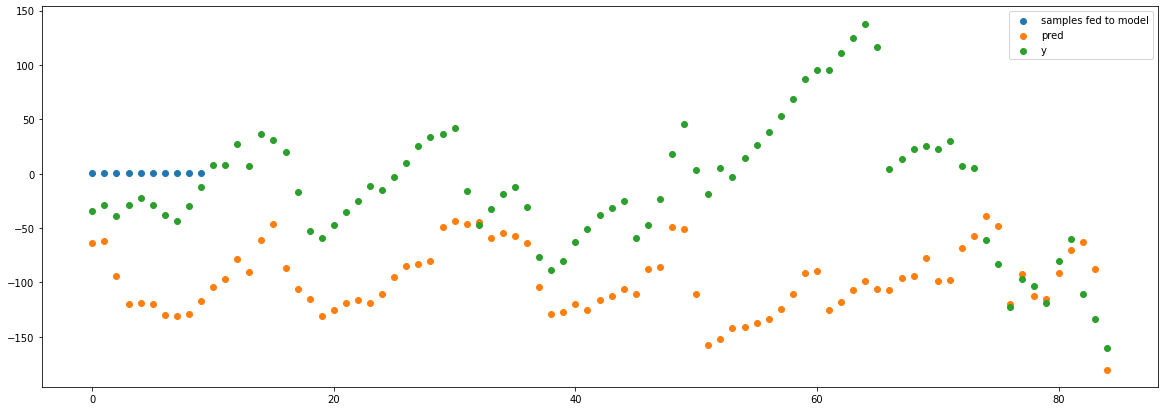

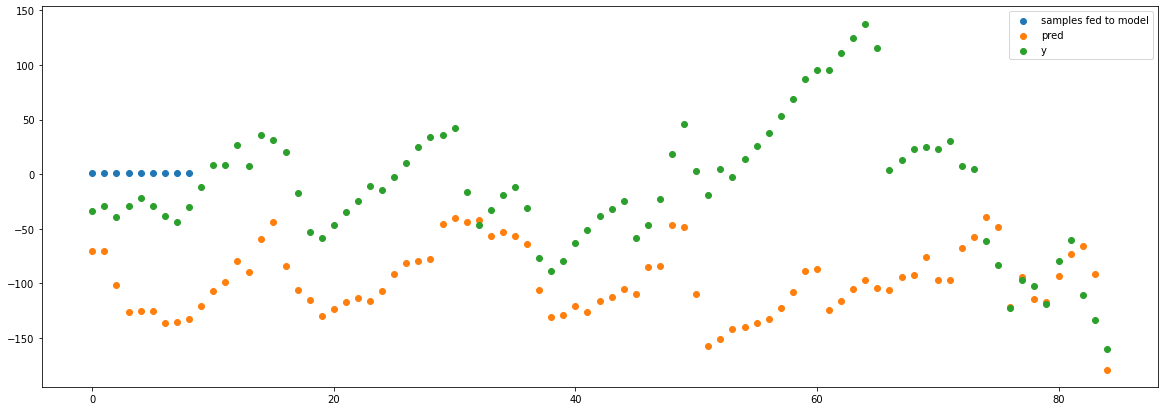

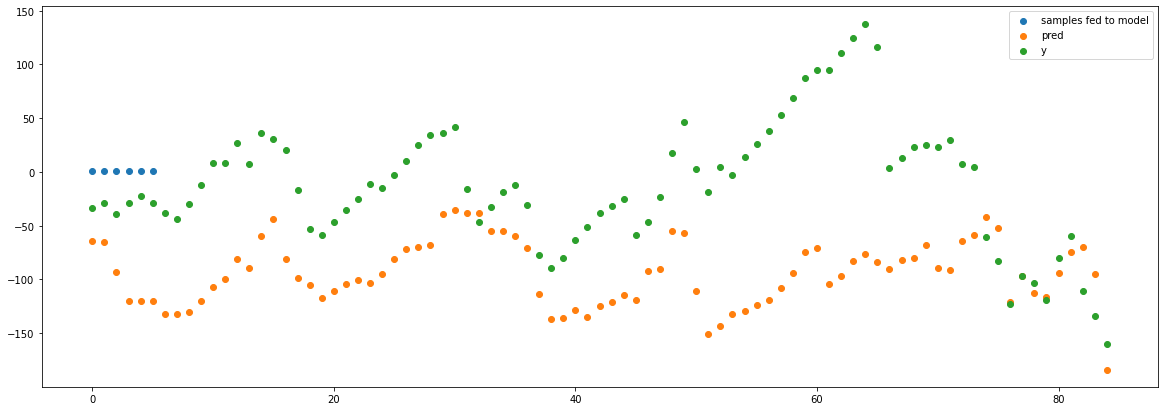

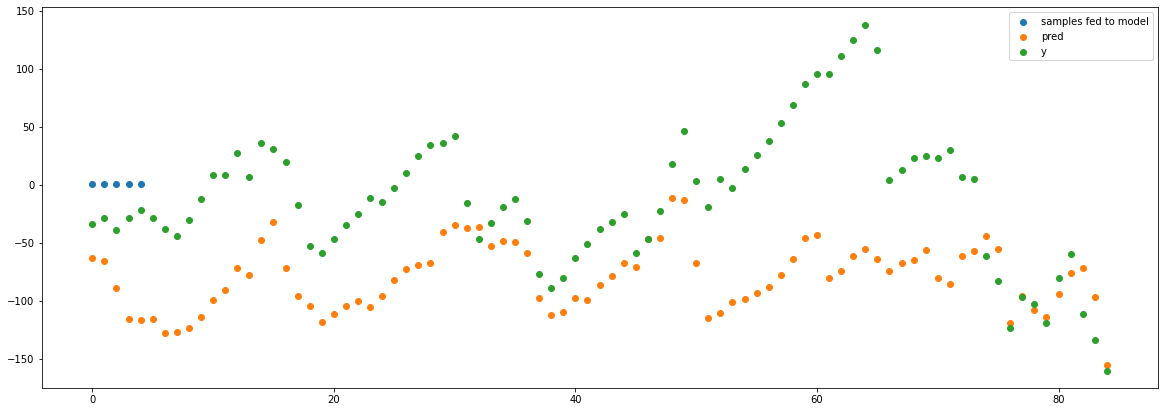

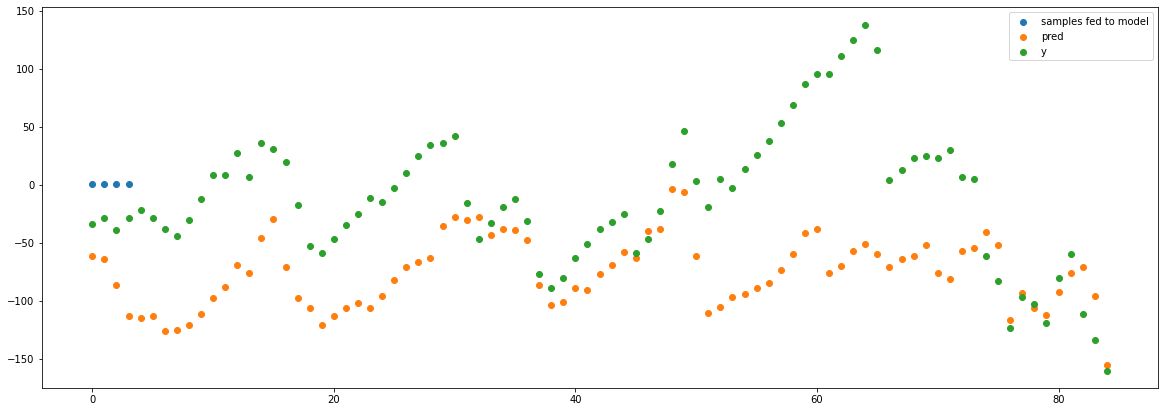

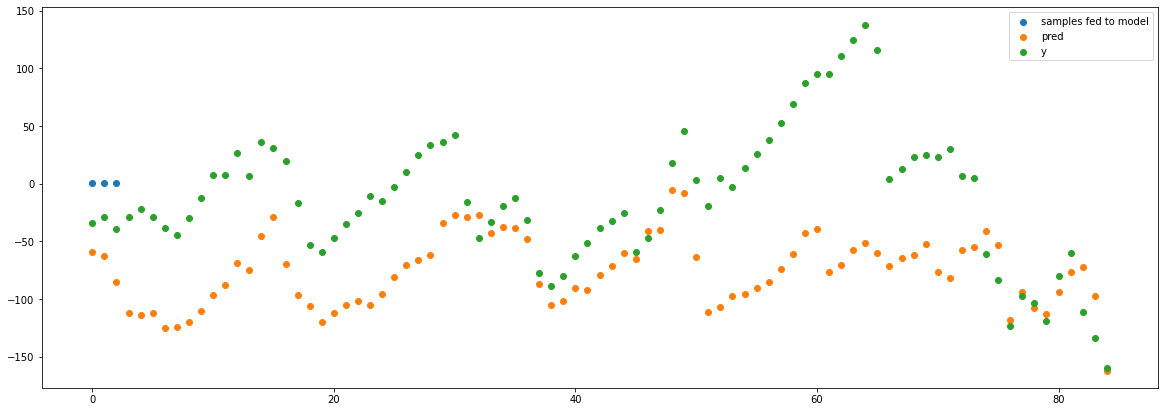

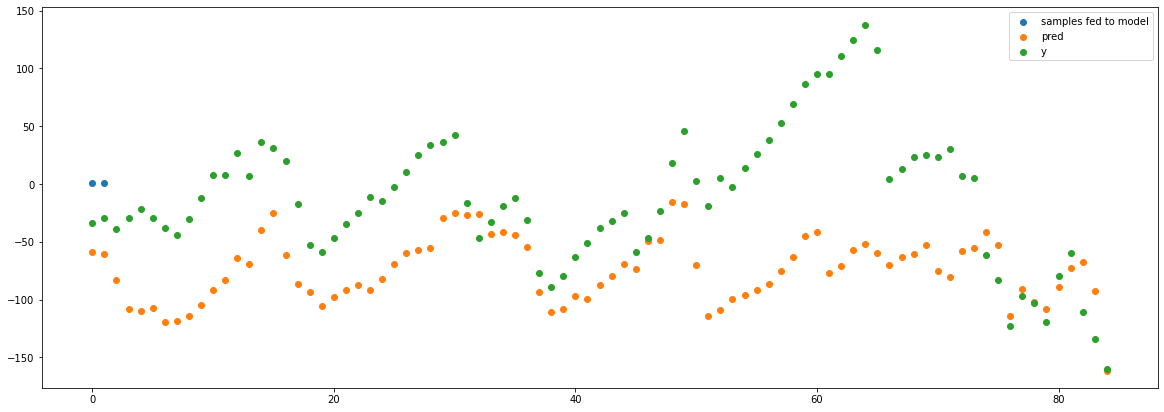

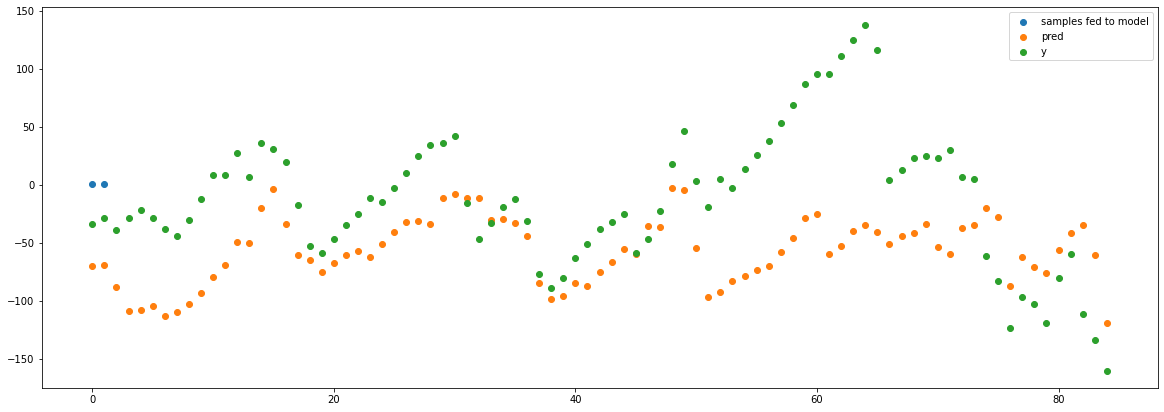

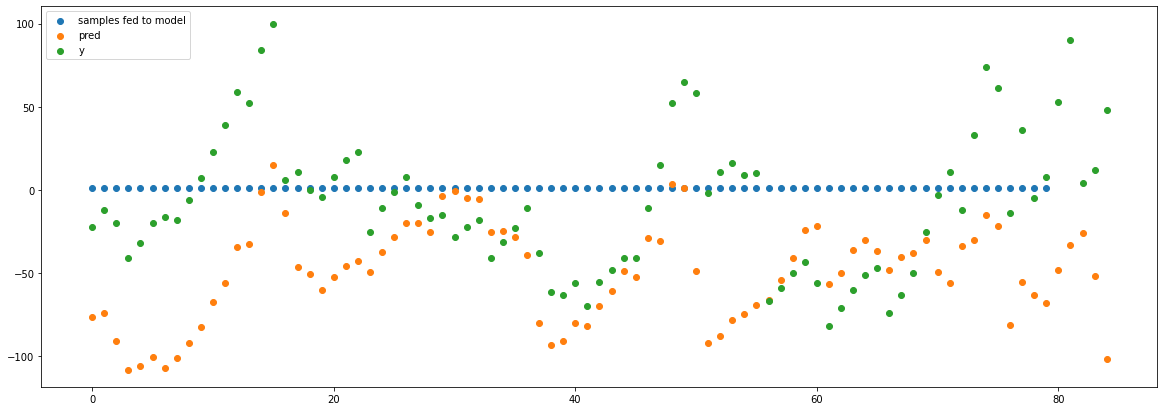

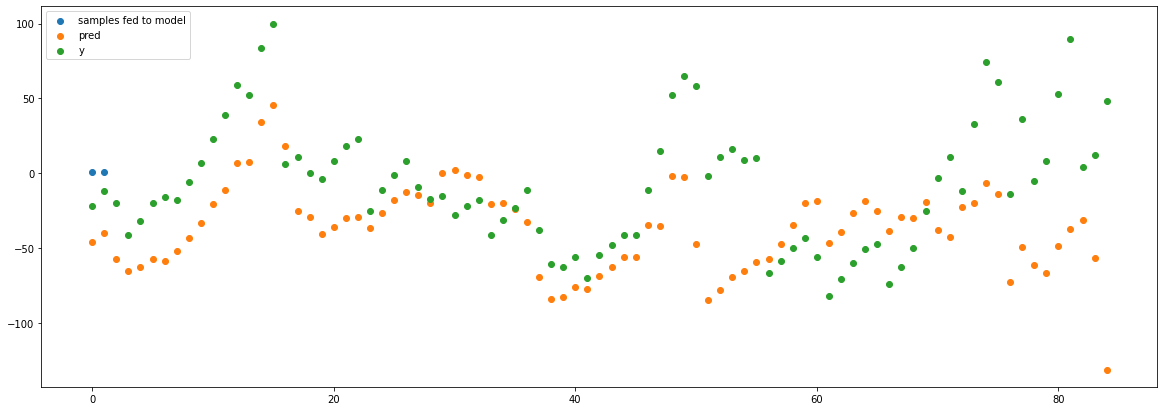

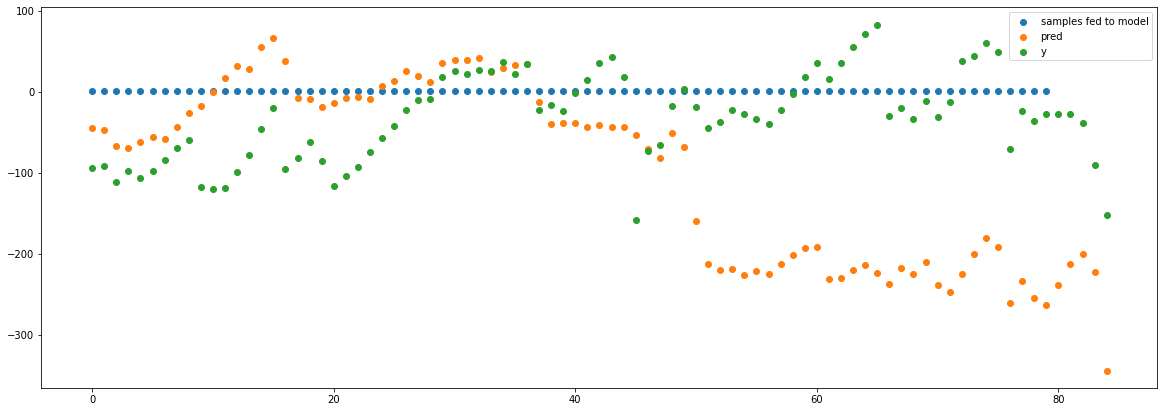

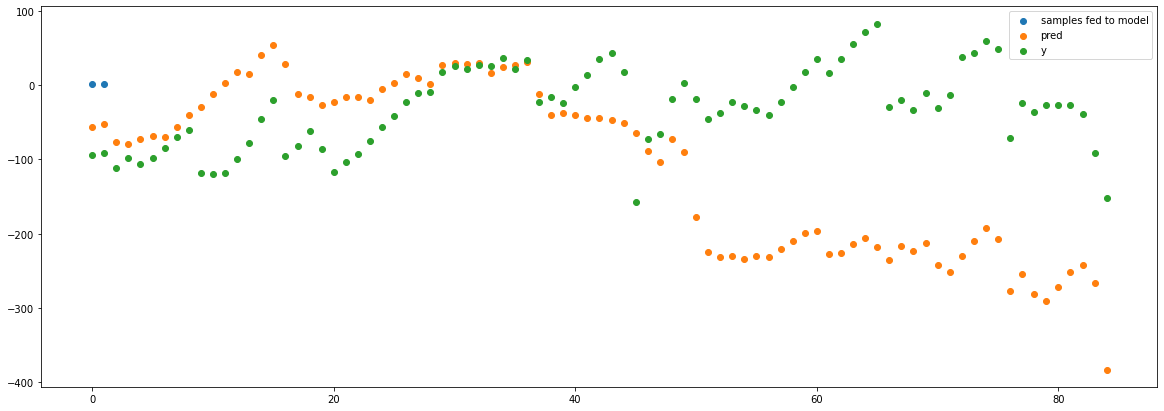

In [16]:
np.set_printoptions(threshold=sys.maxsize)


for i, (pred, y) in enumerate(zip(preds, test_dataset.unbatch().as_numpy_iterator())):
    if i < 100:
        x, y = y
        assert pred.shape[0] == y.shape[0]
        num_samples = x["num_samples"]
        info = [1 for _ in range(num_samples)]
        x_info = list(range(num_samples))
        x = list(range(pred.shape[0]))

        plt.rcParams["figure.figsize"] = [20, 7]
        plt.scatter(x_info, info, label="samples fed to model")
        plt.scatter(x, pred, label="pred")
        plt.scatter(x, y, label="y")
        plt.legend()
        plt.show()

allDone()